In [9]:
import torch
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Found existing installation: torch_scatter 2.1.2+pt24cpu
Uninstalling torch_scatter-2.1.2+pt24cpu:
  Successfully uninstalled torch_scatter-2.1.2+pt24cpu
Found existing installation: torch_sparse 0.6.18+pt24cpu
Uninstalling torch_sparse-0.6.18+pt24cpu:
  Successfully uninstalled torch_sparse-0.6.18+pt24cpu
Found existing installation: torch-geometric 2.7.0
Uninstalling torch-geometric-2.7.0:
  Successfully uninstalled torch-geometric-2.7.0
Found existing installation: torch_cluster 1.6.3+pt24cpu
Uninstalling torch_cluster-1.6.3+pt24cpu:
  Successfully uninstalled torch_cluster-1.6.3+pt24cpu
Looking in links: https://data.pyg.org/whl/torch-2.4.0+cpu.html
  Using cached https://data.pyg.org/whl/torch-2.4.0%2Bcpu/torch_scatter-2.1.2%2Bpt24cpu-cp310-cp310-linux_x86_64.whl (541 kB)
Looking in links: https://data.pyg.org/whl/torch-2.4.0+cpu.html
  Using cached https://data.pyg.org/whl/torch-2.4.0%2Bcpu/torch_sparse-0.6.18%2Bpt24cpu-cp310-cp310-linux_x86_64.whl (1.2 MB)
Looking in links: http

In [2]:
!pip install dive-into-graphs

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 41.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 MB 33.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 54.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.0 MB/s eta 0:00:00
  Created wheel for typed-argument-parser: filename=typed_argument_parser-1.7.2-py3-none-any.whl size=22683 sha256=655268d8534de086f54de6de430c472e83be68e6bc03cf7bd6ae18d7866b1467
  Stored in directory: /root/.cache/pip/wheels/7e/3e/65/0bed56e064aec3760b50245803510ee4fa767ea3a475a89256
  Created wheel for antlr4-python3-runtime: file

In [3]:
from dig.sslgraph.utils import Encoder
from dig.sslgraph.evaluation import GraphSemisupervised, GraphUnsupervised, NodeUnsupervised
from dig.sslgraph.dataset import get_dataset, get_node_dataset
from dig.sslgraph.method import GraphCL, GRACE

In [4]:
import os.path as osp
from itertools import repeat
import os, shutil, torch
import numpy as np

from torch_geometric.data import InMemoryDataset, download_url, extract_zip
from torch_geometric.io import read_tu_data


class TUDatasetExt(InMemoryDataset):
    r"""An extended TUDataset from `Pytorch Geometric 
    <https://pytorch-geometric.readthedocs.io/en/latest/index.html>`_, including
    a variety of graph kernel benchmark datasets, *e.g.* "IMDB-BINARY", 
    "REDDIT-BINARY" or "PROTEINS".

    .. note::
        Some datasets may not come with any node labels.
        You can then either make use of the argument :obj:`use_node_attr`
        to load additional continuous node attributes (if present) or provide
        synthetic node features using transforms such as
        like :class:`torch_geometric.transforms.Constant` or
        :class:`torch_geometric.transforms.OneHotDegree`.

    Args:
        root (string): Root directory where the dataset should be saved.
        name (string): The `name
            <https://chrsmrrs.github.io/datasets/docs/datasets/>`_ of the
            dataset.
        task (string): The evaluation task. Either 'semisupervised' or
            'unsupervised'.
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.Data` object and returns a transformed
            version. The data object will be transformed before every access.
            (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.Data` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
        pre_filter (callable, optional): A function that takes in an
            :obj:`torch_geometric.data.Data` object and returns a boolean
            value, indicating whether the data object should be included in the
            final dataset. (default: :obj:`None`)
        use_node_attr (bool, optional): If :obj:`True`, the dataset will
            contain additional continuous node attributes (if present).
            (default: :obj:`False`)
        use_edge_attr (bool, optional): If :obj:`True`, the dataset will
            contain additional continuous edge attributes (if present).
            (default: :obj:`False`)
        cleaned (bool, optional): If :obj:`True`, the dataset will
            contain only non-isomorphic graphs. (default: :obj:`False`)
        processed_filename (string, optional): The name of the processed data file.
            (default: obj: `data.pt`)
    """
    url = 'https://www.chrsmrrs.com/graphkerneldatasets'
    cleaned_url = ('https://chrsmrrs.github.io/datasets/docs/datasets/')

    def __init__(self,
                 root,
                 name,
                 task,
                 transform=None,
                 pre_transform=None,
                 pre_filter=None,
                 use_node_attr=False,
                 use_edge_attr=False,
                 cleaned=False,
                 processed_filename='data.pt'
                 ):
        self.processed_filename = processed_filename
        self.name = name
        self.cleaned = cleaned
        self.task = task
        super(TUDatasetExt, self).__init__(root, transform, pre_transform, pre_filter)

        if self.task == "semisupervised":
            self.data, self.slices = torch.load(self.processed_paths[0])
            if self.data.x is not None and not use_node_attr:
                num_node_attributes = self.num_node_attributes
                self.data.x = self.data.x[:, num_node_attributes:]
            if self.data.edge_attr is not None and not use_edge_attr:
                num_edge_attributes = self.num_edge_attributes
                self.data.edge_attr = self.data.edge_attr[:, num_edge_attributes:]

        elif self.task == "unsupervised":
            self.data, self.slices = torch.load(self.processed_paths[0])
            if self.data.x is not None and not use_node_attr:
                num_node_attributes = self.num_node_attributes
                self.data.x = self.data.x[:, num_node_attributes:]
            if self.data.edge_attr is not None and not use_edge_attr:
                num_edge_attributes = self.num_edge_attributes
                self.data.edge_attr = self.data.edge_attr[:, num_edge_attributes:]
            if self.data.x is None:
                edge_index = self.data.edge_index[0, :].numpy()
                _, num_edge = self.data.edge_index.size()
                nlist = [edge_index[n] + 1 for n in range(num_edge - 1) if edge_index[n] > edge_index[n + 1]]
                nlist.append(edge_index[-1] + 1)

                num_node = np.array(nlist).sum()
                self.data.x = torch.ones((num_node, 1))

                edge_slice = [0]
                k = 0
                for n in nlist:
                    k = k + n
                    edge_slice.append(k)
                self.slices['x'] = torch.tensor(edge_slice)
        else:
            ValueError("Wrong task name")

    @property
    def raw_dir(self):
        name = 'raw{}'.format('_cleaned' if self.cleaned else '')
        return osp.join(self.root, self.name, name)

    @property
    def processed_dir(self):
        name = 'processed{}'.format('_cleaned' if self.cleaned else '')
        return osp.join(self.root, self.name, name)

    @property
    def num_node_labels(self):
        if self.data.x is None:
            return 0
        for i in range(self.data.x.size(1)):
            x = self.data.x[:, i:]
            if ((x == 0) | (x == 1)).all() and (x.sum(dim=1) == 1).all():
                return self.data.x.size(1) - i
        return 0

    @property
    def num_node_attributes(self):
        if self.data.x is None:
            return 0
        return self.data.x.size(1) - self.num_node_labels

    @property
    def num_edge_labels(self):
        if self.data.edge_attr is None:
            return 0
        for i in range(self.data.edge_attr.size(1)):
            if self.data.edge_attr[:, i:].sum() == self.data.edge_attr.size(0):
                return self.data.edge_attr.size(1) - i
        return 0

    @property
    def num_edge_attributes(self):
        if self.data.edge_attr is None:
            return 0
        return self.data.edge_attr.size(1) - self.num_edge_labels

    @property
    def raw_file_names(self):
        names = ['A', 'graph_indicator']
        return ['{}_{}.txt'.format(self.name, name) for name in names]

    @property
    def processed_file_names(self):
        return self.processed_filename

    def download(self):
        url = self.cleaned_url if self.cleaned else self.url
        folder = osp.join(self.root, self.name)
        path = download_url('{}/{}.zip'.format(url, self.name), folder)
        extract_zip(path, folder)
        os.unlink(path)
        shutil.rmtree(self.raw_dir)
        os.rename(osp.join(folder, self.name), self.raw_dir)

    def process(self):

        self.data, self.slices, temp = read_tu_data(self.raw_dir, self.name)

        if self.pre_filter is not None:
            data_list = [self.get(idx) for idx in range(len(self))]
            data_list = [data for data in data_list if self.pre_filter(data)]
            self.data, self.slices = self.collate(data_list)

        if self.pre_transform is not None:
            data_list = [self.get(idx) for idx in range(len(self))]
            data_list = [self.pre_transform(data) for data in data_list]
            self.data, self.slices = self.collate(data_list)

        torch.save((self.data, self.slices), self.processed_paths[0])

    def __repr__(self):
        return '{}({})'.format(self.name, len(self))

    def get_num_feature(self):
        data = self.data.__class__()

        for key in self.data.keys():
            item, slices = self.data[key], self.slices[key]
            if torch.is_tensor(item):
                s = list(repeat(slice(None), item.dim()))
                s[self.data.__cat_dim__(key, item)] = slice(slices[0], slices[0 + 1])
            else:
                s = slice(slices[idx], slices[idx + 1])
            data[key] = item[s]
        _, num_feature = data.x.size()

        return num_feature

    def get(self, idx):
        data = self.data.__class__()

        for key in self.data.keys():
            if key == 'num_nodes':
                continue
            item, slices = self.data[key], self.slices[key]
            if torch.is_tensor(item):
                s = list(repeat(slice(None), item.dim()))
                s[self.data.__cat_dim__(key, item)] = slice(slices[idx], slices[idx + 1])
            else:
                s = slice(slices[idx], slices[idx + 1])
            data[key] = item[s]

        if self.task == "unsupervised":
            node_num = data.edge_index.max()
            sl = torch.tensor([[n, n] for n in range(node_num)]).t()
            data.edge_index = torch.cat((data.edge_index, sl), dim=1)

        return data

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree, remove_self_loops, add_self_loops
class FeatureExpander(MessagePassing):
    """
    """
    def __init__(self, degree=True, onehot_maxdeg=0, AK=1, centrality=False,
                remove_edges="none", edge_noises_add=0, edge_noises_delete=0, 
                group_degree=0):
        super(FeatureExpander, self).__init__()

        self.degree = degree
        self.onehot_maxdeg = onehot_maxdeg
        self.AK = AK
        self.centrality = centrality
        self.remove_edges = remove_edges
        self.edge_noises_add = edge_noises_add
        self.edge_noises_delete = edge_noises_delete
        self.group_degree = group_degree

        # edge norm is used, and set A diag to it
        self.edge_norm_diag = 1e-8

    def transform(self, data):
        if data.x is None:
            data.x = torch.ones([data.num_nodes, 1], dtype=torch.float)
        
        # ignore edge noises

        deg, deg_onehot = self.compute_degree(data.edge_index, data.num_nodes)
        akx = self.compute_akx(data.num_nodes, data.x, data.edge_index)
        cent = self.compute_centrality(data)
        # data.x = torch.cat([data.x, deg, deg_onehot, akx, cent], dim=-1)
        # data.x = torch.cat([data.x, deg_onehot, akx, cent, deg], dim=-1)
        data.x = torch.cat([deg, data.x, deg_onehot, akx, cent], dim=-1)

        return data
    
    def compute_degree(self, edge_index, num_nodes):
        row, col = edge_index
        deg = degree(row, num_nodes)
        deg = deg.view((-1, 1))

        if self.onehot_maxdeg is not None and self.onehot_maxdeg > 0:
            max_deg = torch.tensor(self.onehot_maxdeg, dtype=deg.dtype)
            deg_capped = torch.min(deg, max_deg).type(torch.int64)
            deg_onehot = nn.functional.one_hot(deg_capped.view(-1), num_classes=self.onehot_maxdeg + 1)
            deg_onehot = deg_onehot.type(deg.dtype)
        else:
            deg_onehot = self.empty_feature(num_nodes)

        if not self.degree:
            deg = self.empty_feature(num_nodes)
        
        return deg, deg_onehot

    
    def compute_akx(self, num_nodes, x, edge_index, edge_weight=None):
        if self.AK is None or self.AK <= 0:
            return self.empty_feature(num_nodes)
    
    def compute_centrality(self, data):
        if not self.centrality:
            return self.empty_feature(data.num_nodes)
    
    def empty_feature(self, num_nodes):
        return torch.zeros([num_nodes, 0])
    
    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

    @staticmethod
    def norm(edge_index, num_nodes, edge_weight, diag_val=1e-8, dtype=None):
        if edge_weight is None:
            edge_weight = torch.ones((edge_index.size(1), ),
                                     dtype=dtype,
                                     device=edge_index.device)
        edge_weight = edge_weight.view(-1)
        assert edge_weight.size(0) == edge_index.size(1)

        edge_index, edge_weight = remove_self_loops(edge_index, edge_weight)
        edge_index = add_self_loops(edge_index, num_nodes=num_nodes)
        # Add edge_weight for loop edges.
        loop_weight = torch.full((num_nodes, ),
                                 diag_val,
                                 dtype=edge_weight.dtype,
                                 device=edge_weight.device)
        edge_weight = torch.cat([edge_weight, loop_weight], dim=0)

        row, col = edge_index
        deg = scatter_add(edge_weight, row, dim=0, dim_size=num_nodes)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0

        return edge_index, deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]


class CatDegOnehot(object):
    r"""Adds the node degree as one hot encodings to the node features.

    Args:
        max_degree (int): Maximum degree.
        in_degree (bool, optional): If set to :obj:`True`, will compute the
            in-degree of nodes instead of the out-degree.
            (default: :obj:`False`)
        cat (bool, optional): Concat node degrees to node features instead
            of replacing them. (default: :obj:`True`)
    """

    def __init__(self, max_degree, in_degree=False, cat=True):
        self.max_degree = max_degree
        self.in_degree = in_degree
        self.cat = cat

    def __call__(self, data):
        idx, x = data.edge_index[1 if self.in_degree else 0], data.x
        deg = degree(idx, data.num_nodes, dtype=torch.long)
        deg = F.one_hot(deg, num_classes=self.max_degree + 1).to(torch.float)

        if x is not None and self.cat:
            x = x.view(-1, 1) if x.dim() == 1 else x
            data.x = torch.cat([x, deg.to(x.dtype)], dim=-1)
        else:
            data.x = deg
            
        return data

    def __repr__(self):
        return '{}({})'.format(self.__class__.__name__, self.max_degree)
    
    
def get_max_deg(dataset):
    max_deg = 0
    for data in dataset:
        row, col = data.edge_index
        num_nodes = data.num_nodes
        deg = degree(row, num_nodes)
        deg = max(deg).item()
        if deg > max_deg:
            max_deg = int(deg)
    return max_deg

In [6]:
import re

from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures


def get_dataset(name, task, feat_str="deg", root=None):
    r"""A pre-implemented function to retrieve graph datasets from TUDataset.
    Depending on evaluation tasks, different node feature augmentation will
    be applied following `GraphCL <https://arxiv.org/abs/2010.13902>`_.

    Args:
        name (string): The `name <https://chrsmrrs.github.io/datasets/docs/datasets/>`_ of the dataset.
        task (string): The evaluation task. Either 'semisupervised' or
            'unsupervised'.
        feat_str (bool, optional): The node feature augmentations to be applied,
            *e.g.*, degrees and centrality. (default: :obj:`deg`)
        root (string, optional): Root directory where the dataset should be saved.
            (default: :obj:`None`)
        
    :rtype: :class:`torch_geometric.data.Dataset` (unsupervised), or (:class:`torch_geometric.data.Dataset`, 
        :class:`torch_geometric.data.Dataset`) (semisupervised).
        
    Examples
    --------
    >>> dataset, dataset_pretrain = get_dataset("NCI1", "semisupervised")
    >>> dataset
    NCI1(4110)
    
    >>> dataset = get_dataset("MUTAG", "unsupervised", feat_str="")
    >>> dataset # degree not augmented as node attributes
    MUTAG(188)
    """

    root = "." if root is None else root
    if task == "semisupervised":

        if name in ['REDDIT-BINARY', 'REDDIT-MULTI-5K', 'REDDIT-MULTI-12K']:
            feat_str = feat_str.replace('odeg100', 'odeg10')
        if name in ['DD']:
            feat_str = feat_str.replace('odeg100', 'odeg10')
            feat_str = feat_str.replace('ak3', 'ak1')

        degree = feat_str.find("deg") >= 0
        onehot_maxdeg = re.findall("odeg(\d+)", feat_str)
        onehot_maxdeg = int(onehot_maxdeg[0]) if onehot_maxdeg else None

        pre_transform = FeatureExpander(degree=degree, 
                                        onehot_maxdeg=onehot_maxdeg, AK=0).transform

        dataset = TUDatasetExt(root+"/semi_dataset/dataset", name, task, 
                               pre_transform=pre_transform, use_node_attr=True,
                               processed_filename="data_%s.pt" % feat_str)

        dataset_pretrain = TUDatasetExt(root+"/semi_dataset/pretrain_dataset/", name, task, 
                                        pre_transform=pre_transform, use_node_attr=True,
                                        processed_filename="data_%s.pt" % feat_str)

        dataset.data.edge_attr = None
        dataset_pretrain.data.edge_attr = None

        return dataset, dataset_pretrain

    elif task == "unsupervised":
        dataset = TUDatasetExt(root+"/unsuper_dataset/", name=name, task=task)
        if feat_str.find("deg") >= 0:
            max_degree = get_max_deg(dataset)
            dataset = TUDatasetExt(root+"./unsuper_dataset/", name=name, task=task,
                                   transform=CatDegOnehot(max_degree), use_node_attr=True)
        return dataset

    else:
        ValueError("Wrong task name")


In [7]:
# dataset, dataset_pretrain = get_dataset('NCI1', task='semisupervised')
# feat_dim = dataset[0].x.shape[1]
# embed_dim = 128

In [8]:
node_dataset = get_node_dataset("Cora")

Processing...
Done!


In [10]:
feat_dim = node_dataset[0].x.shape[1]
embed_dim = 8
print(feat_dim)

1433


In [11]:
import copy
import torch
import numpy as np
import torch.nn as nn
from torch_geometric.data import DataLoader
from sklearn import preprocessing


class LogReg(nn.Module):
    def __init__(self, ft_in, nb_classes):
        super(LogReg, self).__init__()
        self.fc = nn.Linear(ft_in, nb_classes)
        self.sigm = nn.Sigmoid()

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.fill_(0.0)

    def forward(self, seq):
        ret = torch.log_softmax(self.fc(seq), dim=-1)
        return ret


class NodeUnsupervised(object):
    r"""
    The evaluation interface for unsupervised graph representation learning evaluated with 
    linear classification. You can refer to `the benchmark code 
    <https://github.com/divelab/DIG/tree/dig/benchmarks/sslgraph>`_ 
    for examples of usage.
    
    Args:
        full_dataset (torch_geometric.data.Dataset): The graph classification dataset.
        train_mask (Tensor, optional): Boolean tensor of shape :obj:`[n_nodes,]`, indicating 
            nodes for training. Set to :obj:`None` if included in dataset.
            (default: :obj:`None`)
        val_mask (Tensor, optional): Boolean tensor of shape :obj:`[n_nodes,]`, indicating 
            nodes for validation. Set to :obj:`None` if included in dataset.
            (default: :obj:`None`)
        test_mask (Tensor, optional): Boolean tensor of shape :obj:`[n_nodes,]`, indicating 
            nodes for test. Set to :obj:`None` if included in dataset. (default: :obj:`None`)
        classifier (string, optional): Linear classifier for evaluation, :obj:`"SVC"` or 
            :obj:`"LogReg"`. (default: :obj:`"LogReg"`)
        log_interval (int, optional): Perform evaluation per k epochs. (default: :obj:`1`)
        device (int, or torch.device, optional): Device for computation. (default: :obj:`None`)
        **kwargs (optional): Training and evaluation configs in :meth:`setup_train_config`.
        
    Examples
    --------
    >>> node_dataset = get_node_dataset("Cora") # using default train/test split
    >>> evaluator = NodeUnsupervised(node_dataset, log_interval=10, device=0)
    >>> evaluator.evaluate(model, encoder)
    
    >>> node_dataset = SomeDataset()
    >>> # Using your own dataset or with different train/test split
    >>> train_mask, val_mask, test_mask = torch.Tensor([...]), torch.Tensor([...]), torch.Tensor([...])
    >>> evaluator = NodeUnsupervised(node_dataset, train_mask, val_mask, test_mask, log_interval=10, device=0)
    >>> evaluator.evaluate(model, encoder)
    """
    
    def __init__(self, full_dataset, train_mask=None, val_mask=None, test_mask=None, 
                 classifier='LogReg', metric='acc', device=None, log_interval=1, **kwargs):

        self.full_dataset = full_dataset
        self.train_mask = full_dataset[0].train_mask if train_mask is None else train_mask
        self.val_mask = full_dataset[0].val_mask if val_mask is None else val_mask
        self.test_mask = full_dataset[0].test_mask if test_mask is None else test_mask
        self.metric = metric
        self.device = device
        self.classifier = classifier
        self.log_interval = log_interval
        self.num_classes = full_dataset.num_classes
        self.train_losses = []
        self.val_losses = []
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        elif isinstance(device, int):
            self.device = torch.device('cuda:%d'%device)
        else:
            self.device = device

        # Use default config if not further specified
        self.setup_train_config(**kwargs)

    def setup_train_config(self, p_optim = 'Adam', p_lr = 0.01, p_weight_decay = 0, 
                           p_epoch = 2000, logreg_wd = 0, comp_embed_on='cpu'):

        self.p_optim = p_optim
        self.p_lr = p_lr
        self.p_weight_decay = p_weight_decay
        self.p_epoch = p_epoch
        
        self.comp_embed_on = comp_embed_on
        self.logreg_wd = logreg_wd

    def evaluate(self, learning_model, encoder):
        r"""Run evaluation with given learning model and encoder(s).
        
        Args:
            learning_model: An object of a contrastive model (sslgraph.method.Contrastive)
                or a predictive model.
            encoder (torch.nn.Module): Trainable pytorch model or list of models.

        :rtype: (float, float)
        """
        self.train_losses = []
        self.val_losses = []

        full_loader = DataLoader(self.full_dataset, 1)
        if isinstance(encoder, list):
            params = [{'params': enc.parameters()} for enc in encoder]
        else:
            params = encoder.parameters()
        
        p_optimizer = self.get_optim(self.p_optim)(params, lr=self.p_lr, 
                                                   weight_decay=self.p_weight_decay)

        test_scores_m, test_scores_sd = [], []
        per_epoch_out = (self.log_interval<self.p_epoch)
        for i, enc in enumerate(learning_model.train(encoder, full_loader, 
                                                     p_optimizer, self.p_epoch, per_epoch_out)):
            if not per_epoch_out or (i+1)%self.log_interval==0:
                embed, lbls = self.get_embed(enc.to(self.device), full_loader)
                lbs = np.array(preprocessing.LabelEncoder().fit_transform(lbls))
                
                test_scores = []
                for _ in range(10):
                    test_score = self.get_clf()(embed[self.train_mask], lbls[self.train_mask],
                                                embed[self.test_mask], lbls[self.test_mask])
                    test_scores.append(test_score)
                
                test_scores = torch.tensor(test_scores)
                test_score_mean = test_scores.mean().item()
                test_score_std = test_scores.std().item() 
                test_scores_m.append(test_score_mean)
                test_scores_sd.append(test_score_std)
                
        idx = np.argmax(test_scores_m)
        acc = test_scores_m[idx]
        std = test_scores_sd[idx]
        print("ACCURACY: ", test_scores_m)
        print(test_scores_sd)
        print('Best epoch %d: acc %.4f (+/- %.4f).'%((idx+1)*self.log_interval, acc, std))
        return acc
    
    
    def evaluate_multisplits(self, learning_model, encoder, split_masks):
        r"""Run evaluation with given learning model and encoder(s), return averaged scores 
        on multiple different splits.
        
        Args:
            learning_model: An object of a contrastive model (sslgraph.method.Contrastive)
                or a predictive model.
            encoder (torch.nn.Module): Trainable pytorch model or list of models.
            split_masks (list, or generator): A list of generator that contains or yields masks for
                train, val and test splits.

        :rtype: float

        Example
        -------
        >>> split_masks = [(train1, val1, test1), (train2, val2, test2), ..., (train20, val20, test20)]
        """
        
        full_loader = DataLoader(self.full_dataset, 1)
        if isinstance(encoder, list):
            params = [{'params': enc.parameters()} for enc in encoder]
        else:
            params = encoder.parameters()
        
        p_optimizer = self.get_optim(self.p_optim)(params, lr=self.p_lr, 
                                                   weight_decay=self.p_weight_decay)

        test_scores_m, test_scores_sd = [], []
        per_epoch_out = (self.log_interval<self.p_epoch)
        for i, enc in enumerate(learning_model.train(encoder, full_loader, 
                                                     p_optimizer, self.p_epoch, per_epoch_out)):
            if not per_epoch_out or (i+1)%self.log_interval==0:
                embed, lbls = self.get_embed(enc.to(self.device), full_loader)
                lbs = np.array(preprocessing.LabelEncoder().fit_transform(lbls))
                
                test_scores = []
                for train_mask, val_mask, test_mask in split_masks:
                    test_score = self.get_clf()(embed[train_mask], lbls[train_mask],
                                                embed[test_mask], lbls[test_mask])
                    test_scores.append(test_score)
                
                test_scores = torch.tensor(test_scores)
                test_score_mean = test_scores.mean().item()
                test_score_std = test_scores.std().item() 
                test_scores_m.append(test_score_mean)
                test_scores_sd.append(test_score_std)
                
        idx = np.argmax(test_scores_m)
        acc = test_scores_m[idx]
        std = test_scores_sd[idx]
        print('Best epoch %d: acc %.4f (+/- %.4f).'%((idx+1)*self.log_interval, acc, std))
        return acc


    def grid_search(self, learning_model, encoder, p_lr_lst=[0.1,0.01,0.001], 
                    p_epoch_lst=[2000]):
        r"""Perform grid search on learning rate and epochs in pretraining.
        
        Args:
            learning_model: An object of a contrastive model (sslgraph.method.Contrastive) 
                or a predictive model.
            encoder (torch.nn.Module): Trainable pytorch model or list of models.
            p_lr_lst (list, optional): List of learning rate candidates.
            p_epoch_lst (list, optional): List of epochs number candidates.

        :rtype: (float, float, (float, int))
        """
        
        acc_m_lst = []
        acc_sd_lst = []
        paras = []
        for p_lr in p_lr_lst:
            for p_epoch in p_epoch_lst:
                self.setup_train_config(p_lr=p_lr, p_epoch=p_epoch)
                model = copy.deepcopy(learning_model)
                enc = copy.deepcopy(encoder)
                acc_m, acc_sd = self.evaluate(model, enc)
                acc_m_lst.append(acc_m)
                acc_sd_lst.append(acc_sd)
                paras.append((p_lr, p_epoch))
        idx = np.argmax(acc_m_lst)
        print('Best paras: %d epoch, lr=%f, acc=%.4f' %(
            paras[idx][1], paras[idx][0], acc_m_lst[idx]))
        
        return acc_m_lst[idx], acc_sd_lst[idx], paras[idx]

    
    def svc_clf(self, train_embs, train_lbls, test_embs, test_lbls):

        if self.search:
            params = {'C':[0.001, 0.01,0.1,1,10,100,1000]}
            classifier = GridSearchCV(SVC(), params, cv=5, scoring='accuracy', verbose=0)
        else:
            classifier = SVC(C=10)

        classifier.fit(train_embs, train_lbls)
        acc = accuracy_score(test_lbls, classifier.predict(test_embs))
            
        return acc
    
    
    def log_reg(self, train_embs, train_lbls, test_embs, test_lbls):
        
        hid_units = train_embs.shape[1]
        train_embs = torch.from_numpy(train_embs).to(self.device)
        train_lbls = torch.from_numpy(train_lbls).to(self.device)
        test_embs = torch.from_numpy(test_embs).to(self.device)
        test_lbls = torch.from_numpy(test_lbls).to(self.device)

        xent = nn.CrossEntropyLoss()
        log = LogReg(hid_units, self.num_classes)
        log.to(self.device)
        opt = torch.optim.Adam(log.parameters(), lr=0.01, 
                               weight_decay=self.logreg_wd)

        best_val = 0
        test_acc = None
        for it in range(300):
            log.train()
            opt.zero_grad()

            logits = log(train_embs)
            loss = xent(logits, train_lbls)
            
            loss.backward()
            opt.step()

        logits = log(test_embs)
        preds = torch.argmax(logits, dim=1)
        acc = torch.sum(preds == test_lbls).float() / test_lbls.shape[0]
        
        return acc.item()
    
    
    def get_embed(self, model, loader):
    
        model.eval()
        model.to(self.comp_embed_on)
        ret, y = [], []
        with torch.no_grad():
            for data in loader:
                y.append(data.y.numpy())
                data.to(self.comp_embed_on)
                embed = model(data)
                ret.append(embed.cpu().numpy())
                
        model.to(self.device)
        ret = np.concatenate(ret, 0)
        y = np.concatenate(y, 0)
        return ret, y
        
        
    def get_clf(self):
        
        if self.classifier == 'SVC':
            return self.svc_clf
        elif self.classifier == 'LogReg':
            return self.log_reg
        else:
            return None
        
    
    def get_optim(self, optim):
        
        optims = {'Adam': torch.optim.Adam}
        
        return optims[optim]

In [18]:
dataset = get_node_dataset('cora')
embed_dim =64

encoder = Encoder(feat_dim=dataset[0].x.shape[1], hidden_dim=embed_dim,
                  n_layers=4 , gnn='gcn', node_level=True, graph_level=False)
grace = GRACE(dim=embed_dim, dropE_rate_1=0.2, dropE_rate_2=0.4,
              maskN_rate_1=0.3, maskN_rate_2=0.4, tau=0.4)
             
evaluator = NodeUnsupervised(dataset, log_interval=1)
evaluator.setup_train_config(p_lr=0.0010, p_epoch=2000, p_weight_decay=1e-5, comp_embed_on='cpu')
test_mean = evaluator.evaluate(learning_model=grace, encoder=encoder)

/opt/conda/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Pretraining: epoch 1:   0%|          | 0/2000 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)
Pretraining: epoch 2:   0%|          | 1/2000 [00:02<1:31:07,  2.74s/it, loss=8.596006]/opt/conda/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)
Pretraining: epoch 3:   0%|          | 2/2000 [00:05<1:30:21,  2.71s/it, loss=8.595876]/opt/conda/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)
Pretraining: epoch 4:   0%|          | 3/2000 [00:08<1:29:20,  2.68s/it, loss=8.597139]/opt/con

ACCURACY:  [0.4529000222682953, 0.42480000853538513, 0.4361000061035156, 0.4423999786376953, 0.4537000060081482, 0.45160001516342163, 0.4629000723361969, 0.4764999747276306, 0.48240000009536743, 0.4869000017642975, 0.4880000054836273, 0.48569998145103455, 0.48680001497268677, 0.48989996314048767, 0.4956999719142914, 0.4956999719142914, 0.48190003633499146, 0.48559999465942383, 0.506100058555603, 0.5108000040054321, 0.5128999948501587, 0.5156000256538391, 0.5156000256538391, 0.5163999795913696, 0.5184999704360962, 0.5171999931335449, 0.5240999460220337, 0.527400016784668, 0.536799967288971, 0.5375000238418579, 0.5390999913215637, 0.5382999777793884, 0.5379000306129456, 0.5371999740600586, 0.5414000153541565, 0.5400999784469604, 0.5365000367164612, 0.5326000452041626, 0.5287999510765076, 0.5205000042915344, 0.5148999691009521, 0.511900007724762, 0.5127000212669373, 0.5139999985694885, 0.5156999826431274, 0.5324999690055847, 0.5402000546455383, 0.5470000505447388, 0.5464999675750732, 0.53

In [ ]:
# GITHUB
# 100 epochs training and loss plots(try different optimizers)

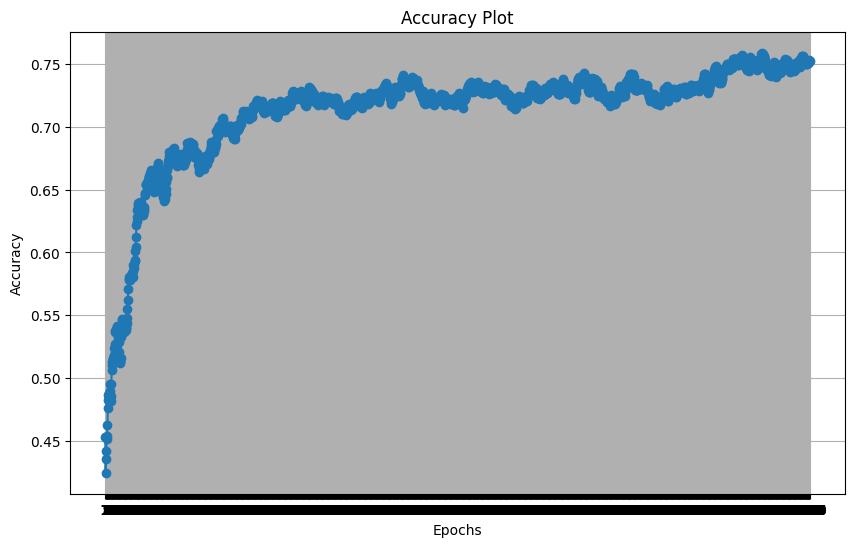

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Your array of values (I'll use a placeholder - please replace with your actual data)
values =[0.4529000222682953, 0.42480000853538513, 0.4361000061035156, 0.4423999786376953, 0.4537000060081482, 0.45160001516342163, 0.4629000723361969, 0.4764999747276306, 0.48240000009536743, 0.4869000017642975, 0.4880000054836273, 0.48569998145103455, 0.48680001497268677, 0.48989996314048767, 0.4956999719142914, 0.4956999719142914, 0.48190003633499146, 0.48559999465942383, 0.506100058555603, 0.5108000040054321, 0.5128999948501587, 0.5156000256538391, 0.5156000256538391, 0.5163999795913696, 0.5184999704360962, 0.5171999931335449, 0.5240999460220337, 0.527400016784668, 0.536799967288971, 0.5375000238418579, 0.5390999913215637, 0.5382999777793884, 0.5379000306129456, 0.5371999740600586, 0.5414000153541565, 0.5400999784469604, 0.5365000367164612, 0.5326000452041626, 0.5287999510765076, 0.5205000042915344, 0.5148999691009521, 0.511900007724762, 0.5127000212669373, 0.5139999985694885, 0.5156999826431274, 0.5324999690055847, 0.5402000546455383, 0.5470000505447388, 0.5464999675750732, 0.5397000312805176, 0.5393000245094299, 0.5400000214576721, 0.5406000018119812, 0.5365000367164612, 0.538100004196167, 0.538100004196167, 0.5401999950408936, 0.5377000570297241, 0.5386000275611877, 0.539900004863739, 0.540399968624115, 0.5436999797821045, 0.5479000210762024, 0.5550999641418457, 0.5623999834060669, 0.5712999701499939, 0.5786999464035034, 0.5805000066757202, 0.5781999826431274, 0.5780999660491943, 0.5789999961853027, 0.5795999765396118, 0.579300045967102, 0.5793999433517456, 0.5821000337600708, 0.583299994468689, 0.5807999968528748, 0.5812999606132507, 0.5803999900817871, 0.5851000547409058, 0.589900016784668, 0.5873000025749207, 0.5909000635147095, 0.5928999781608582, 0.5939000248908997, 0.6010000109672546, 0.6043999791145325, 0.6119999885559082, 0.6218000650405884, 0.6252999901771545, 0.6282000541687012, 0.6337000131607056, 0.6362000107765198, 0.6378000378608704, 0.6389999985694885, 0.6358999609947205, 0.635200023651123, 0.6378999948501587, 0.6366999745368958, 0.6401999592781067, 0.6358000040054321, 0.6400999426841736, 0.6335999965667725, 0.6340999603271484, 0.6365999579429626, 0.6299999952316284, 0.6304000020027161, 0.6297000050544739, 0.6313000321388245, 0.6330999732017517, 0.6342999935150146, 0.6359999775886536, 0.6458999514579773, 0.6467999219894409, 0.6473000049591064, 0.6541000604629517, 0.6541000008583069, 0.6538000106811523, 0.6550999879837036, 0.6540999412536621, 0.6546000242233276, 0.6541000008583069, 0.657200038433075, 0.6610999703407288, 0.6599000096321106, 0.6597000360488892, 0.6627000570297241, 0.6611000299453735, 0.6632999181747437, 0.6629000902175903, 0.6618000268936157, 0.6657999753952026, 0.6579000353813171, 0.6565999984741211, 0.6527000069618225, 0.6518999338150024, 0.6504000425338745, 0.6477999687194824, 0.6521000266075134, 0.6518000364303589, 0.6530999541282654, 0.6536000967025757, 0.6592000722885132, 0.6583000421524048, 0.6586999893188477, 0.6613999605178833, 0.6617000102996826, 0.6597999334335327, 0.6674999594688416, 0.6692999601364136, 0.6709999442100525, 0.6693999767303467, 0.6662999987602234, 0.6661999821662903, 0.6633999943733215, 0.6645999550819397, 0.6639000177383423, 0.6597999930381775, 0.6596999764442444, 0.6562000513076782, 0.6545999646186829, 0.6495999693870544, 0.6468999981880188, 0.6503999829292297, 0.6450999975204468, 0.6439000368118286, 0.6439999938011169, 0.6411000490188599, 0.6426999568939209, 0.6425999402999878, 0.6474999785423279, 0.6460999846458435, 0.6501999497413635, 0.6563000679016113, 0.6603000164031982, 0.6588999629020691, 0.6657000184059143, 0.6687999963760376, 0.6704999804496765, 0.6723999977111816, 0.6743999719619751, 0.6798000335693359, 0.6766999959945679, 0.6744000315666199, 0.673799991607666, 0.6794999837875366, 0.6710999608039856, 0.6715999841690063, 0.6717999577522278, 0.6728000044822693, 0.6722999811172485, 0.678100049495697, 0.6820999383926392, 0.6799999475479126, 0.6810000538825989, 0.6830000281333923, 0.6801999807357788, 0.6788999438285828, 0.6759999990463257, 0.6719000339508057, 0.6725999712944031, 0.6723999977111816, 0.6771000623703003, 0.66920006275177, 0.6686000227928162, 0.669700026512146, 0.6708999872207642, 0.673799991607666, 0.6732000112533569, 0.6739000082015991, 0.6741999387741089, 0.6726000905036926, 0.6764000058174133, 0.6776000261306763, 0.678600013256073, 0.6743000149726868, 0.6738000512123108, 0.6732999086380005, 0.6748000383377075, 0.6736000180244446, 0.669700026512146, 0.6697999238967896, 0.66920006275177, 0.6695999503135681, 0.6726999282836914, 0.6747000813484192, 0.6752000451087952, 0.6718999743461609, 0.674500048160553, 0.6746000051498413, 0.6777999997138977, 0.6825000047683716, 0.6868000030517578, 0.6807000041007996, 0.6789000034332275, 0.6814000010490417, 0.6822999715805054, 0.6861000061035156, 0.6868000030517578, 0.6852000951766968, 0.6881999969482422, 0.6857999563217163, 0.6870999932289124, 0.681399941444397, 0.6831000447273254, 0.682200014591217, 0.6831000447273254, 0.6843000054359436, 0.685200035572052, 0.6864999532699585, 0.6830999851226807, 0.6814000010490417, 0.6798999309539795, 0.675599992275238, 0.676099956035614, 0.6780999898910522, 0.680899977684021, 0.6785999536514282, 0.6791999936103821, 0.6790000200271606, 0.6771000027656555, 0.6748999357223511, 0.6735000014305115, 0.6723999977111816, 0.6699000597000122, 0.6691001057624817, 0.6662999987602234, 0.663599967956543, 0.6660000085830688, 0.6665999889373779, 0.6674999594688416, 0.6673000454902649, 0.6693000197410583, 0.6708999872207642, 0.6704000234603882, 0.6694999933242798, 0.672200083732605, 0.6711000204086304, 0.6694000363349915, 0.6696000099182129, 0.6662999391555786, 0.6691998839378357, 0.670799970626831, 0.6753999590873718, 0.6766999959945679, 0.6746000051498413, 0.6736000180244446, 0.6724000573158264, 0.6707000136375427, 0.6718999743461609, 0.6736999750137329, 0.6734999418258667, 0.6739999651908875, 0.674500048160553, 0.676099956035614, 0.6792000532150269, 0.6773999929428101, 0.6801999807357788, 0.6811999082565308, 0.6840000152587891, 0.685200035572052, 0.6875, 0.6862000226974487, 0.6866000294685364, 0.6850000619888306, 0.6866000294685364, 0.6843999624252319, 0.6814000010490417, 0.6801999807357788, 0.6816999316215515, 0.6836000084877014, 0.683899998664856, 0.6833000183105469, 0.6865000128746033, 0.6899000406265259, 0.6969000101089478, 0.6958000063896179, 0.6976999044418335, 0.6961000561714172, 0.6927000284194946, 0.6965000033378601, 0.6987000107765198, 0.6997999548912048, 0.7001999616622925, 0.7003000378608704, 0.7008000612258911, 0.7008000016212463, 0.7013999819755554, 0.7021000385284424, 0.7003999948501587, 0.7037999629974365, 0.7037999629974365, 0.7057000398635864, 0.7055000066757202, 0.7066999673843384, 0.704800009727478, 0.7015999555587769, 0.6991000175476074, 0.697100043296814, 0.6972000002861023, 0.6960000395774841, 0.696600079536438, 0.6963000297546387, 0.6984999775886536, 0.6987000703811646, 0.6980000138282776, 0.6992999911308289, 0.6973999738693237, 0.6998000144958496, 0.6985999941825867, 0.6985999345779419, 0.6977999806404114, 0.6982999444007874, 0.6982001066207886, 0.7003999948501587, 0.7003999948501587, 0.6994999647140503, 0.7005000114440918, 0.6976999640464783, 0.6962000131607056, 0.6958000063896179, 0.6929999589920044, 0.6933000683784485, 0.6913000345230103, 0.6917000412940979, 0.692300021648407, 0.6899000406265259, 0.6899999976158142, 0.6948999166488647, 0.6945000290870667, 0.6983999609947205, 0.6978999972343445, 0.7005999684333801, 0.6990999579429626, 0.6982000470161438, 0.7013999819755554, 0.7015000581741333, 0.6996999979019165, 0.6970000267028809, 0.6993000507354736, 0.6999000310897827, 0.7031000256538391, 0.70169997215271, 0.7016000151634216, 0.7023999691009521, 0.7069000005722046, 0.7056999802589417, 0.7060999870300293, 0.7067999839782715, 0.7076999545097351, 0.7087000608444214, 0.7114999890327454, 0.7124999761581421, 0.7107000350952148, 0.7081999778747559, 0.7064999938011169, 0.7078999876976013, 0.7089000940322876, 0.7112000584602356, 0.709600031375885, 0.7120999693870544, 0.7117000222206116, 0.7101000547409058, 0.7094999551773071, 0.709600031375885, 0.7084000706672668, 0.7079000473022461, 0.7073999643325806, 0.7061000466346741, 0.7097000479698181, 0.7101000547409058, 0.7101999521255493, 0.7093999981880188, 0.7104999423027039, 0.7102000117301941, 0.7075999975204468, 0.708299994468689, 0.7113999724388123, 0.7135000228881836, 0.7135000228881836, 0.7164999842643738, 0.7150999903678894, 0.7150999903678894, 0.715399980545044, 0.7166000008583069, 0.7157999873161316, 0.7171000242233276, 0.7170000076293945, 0.7162999510765076, 0.7193000912666321, 0.7211999297142029, 0.7207000255584717, 0.718999981880188, 0.7179999351501465, 0.7180999517440796, 0.7185999751091003, 0.719700038433075, 0.717199981212616, 0.715499997138977, 0.7165000438690186, 0.717400074005127, 0.7175000309944153, 0.7177000045776367, 0.7181000113487244, 0.7202999591827393, 0.718500018119812, 0.7172999382019043, 0.7164000272750854, 0.7122999429702759, 0.7109999656677246, 0.7116000056266785, 0.7143999934196472, 0.7144999504089355, 0.7141000032424927, 0.7142000198364258, 0.7129000425338745, 0.711400032043457, 0.7133000493049622, 0.7133000493049622, 0.7131999731063843, 0.7121999859809875, 0.7149999737739563, 0.7161999940872192, 0.7134999632835388, 0.7129000425338745, 0.7143999338150024, 0.71670001745224, 0.7164000272750854, 0.7141000628471375, 0.7146999835968018, 0.7150999903678894, 0.7166999578475952, 0.7187000513076782, 0.7192000150680542, 0.7186000943183899, 0.7189000248908997, 0.7160999774932861, 0.7145000696182251, 0.7122999429702759, 0.7125999927520752, 0.7117999792098999, 0.7131999731063843, 0.7103000283241272, 0.7088000178337097, 0.7101999521255493, 0.7109999656677246, 0.7081999778747559, 0.7107000350952148, 0.7077000141143799, 0.7101000547409058, 0.7105000615119934, 0.7127000093460083, 0.7143999934196472, 0.7127999067306519, 0.716499924659729, 0.7171999216079712, 0.720300018787384, 0.7195000052452087, 0.7192000150680542, 0.7190999984741211, 0.715399980545044, 0.7133998870849609, 0.7134000062942505, 0.7132999300956726, 0.7138000130653381, 0.7142999768257141, 0.7152000665664673, 0.7157000303268433, 0.71399986743927, 0.7128999829292297, 0.7132999897003174, 0.7150000333786011, 0.7145999670028687, 0.7147000432014465, 0.7168999910354614, 0.7157999873161316, 0.7170000076293945, 0.717799961566925, 0.7163999676704407, 0.7208999395370483, 0.7211000323295593, 0.7205000519752502, 0.7164000272750854, 0.7167999744415283, 0.7166999578475952, 0.7197999954223633, 0.7187999486923218, 0.7202000021934509, 0.7196999788284302, 0.7214000225067139, 0.723300039768219, 0.7264000177383423, 0.7275999784469604, 0.728399932384491, 0.7275999784469604, 0.7276999950408936, 0.7257000207901001, 0.722800076007843, 0.7229999899864197, 0.7218000292778015, 0.7231999635696411, 0.7222999930381775, 0.7235000729560852, 0.7232999801635742, 0.7264000177383423, 0.7265000343322754, 0.7262000441551208, 0.7250999808311462, 0.72489994764328, 0.7236000299453735, 0.7250000238418579, 0.7263000011444092, 0.7259000539779663, 0.7238999605178833, 0.7264000177383423, 0.7282000184059143, 0.7261999845504761, 0.7246999740600586, 0.7226999998092651, 0.7208999991416931, 0.722000002861023, 0.7210000157356262, 0.7214000225067139, 0.7209000587463379, 0.7211000323295593, 0.7217000722885132, 0.7213000059127808, 0.7186000347137451, 0.7175999879837036, 0.7166000008583069, 0.7214000821113586, 0.7189000248908997, 0.7196000218391418, 0.7195000052452087, 0.7214000225067139, 0.7225000262260437, 0.7225000262260437, 0.7238999605178833, 0.7281000018119812, 0.7312999963760376, 0.7305999994277954, 0.7297999858856201, 0.729200005531311, 0.7290999889373779, 0.7289000153541565, 0.7289999723434448, 0.7286999225616455, 0.7261999845504761, 0.7261999845504761, 0.7240999937057495, 0.7254000902175903, 0.7259000539779663, 0.7254999279975891, 0.7240999937057495, 0.7236999273300171, 0.7207000851631165, 0.7210999727249146, 0.719700038433075, 0.7188999652862549, 0.7203000783920288, 0.7195999026298523, 0.7193000316619873, 0.7187000513076782, 0.7182000279426575, 0.7192999720573425, 0.7175999879837036, 0.718500018119812, 0.7196999788284302, 0.7199000120162964, 0.7213000059127808, 0.7205999493598938, 0.7210000157356262, 0.7224999666213989, 0.7218000292778015, 0.7214000225067139, 0.7215999960899353, 0.7243000268936157, 0.7245000004768372, 0.7217999696731567, 0.720300018787384, 0.7187999486923218, 0.7196000218391418, 0.7172999978065491, 0.7203999757766724, 0.7213000655174255, 0.7211000323295593, 0.7201000452041626, 0.7203000783920288, 0.7212001085281372, 0.722000002861023, 0.7210000157356262, 0.7222000360488892, 0.7224000692367554, 0.7232999801635742, 0.7221999764442444, 0.7214000225067139, 0.7208999991416931, 0.7218999862670898, 0.722100019454956, 0.7203000783920288, 0.7194001078605652, 0.7193999886512756, 0.7198000550270081, 0.7227000594139099, 0.7223000526428223, 0.7213000059127808, 0.7211000323295593, 0.7196999788284302, 0.7181000113487244, 0.7205000519752502, 0.7182999849319458, 0.7181000113487244, 0.7179999947547913, 0.7211000323295593, 0.722800076007843, 0.723099946975708, 0.722599983215332, 0.722000002861023, 0.7184999585151672, 0.7193000316619873, 0.7163000106811523, 0.7180999517440796, 0.7173000574111938, 0.7167999148368835, 0.7127000093460083, 0.7146000266075134, 0.7143999934196472, 0.7134000062942505, 0.7115999460220337, 0.713200032711029, 0.7128000259399414, 0.7117999792098999, 0.7113000154495239, 0.7099000215530396, 0.7101000547409058, 0.7130999565124512, 0.7128999829292297, 0.7129999995231628, 0.7125999331474304, 0.7108999490737915, 0.7118999361991882, 0.7125999331474304, 0.7110000252723694, 0.7096000909805298, 0.7102999687194824, 0.7106999754905701, 0.7155999541282654, 0.7149999737739563, 0.7157000303268433, 0.7168999910354614, 0.7160000205039978, 0.7163000106811523, 0.7182999849319458, 0.7159000039100647, 0.7154000401496887, 0.7161000370979309, 0.7161999940872192, 0.7141000032424927, 0.7129999995231628, 0.7145000100135803, 0.7143000364303589, 0.7152999639511108, 0.7161999940872192, 0.7158000469207764, 0.716499924659729, 0.717199981212616, 0.7179999947547913, 0.7202000617980957, 0.7221999764442444, 0.7226999998092651, 0.7214001417160034, 0.7233999967575073, 0.7233999967575073, 0.7236999869346619, 0.7216000556945801, 0.7225000262260437, 0.7204000353813171, 0.7214000225067139, 0.7190999388694763, 0.7214000225067139, 0.7184000611305237, 0.718500018119812, 0.7176999449729919, 0.7199000120162964, 0.7165000438690186, 0.7157999873161316, 0.7154000401496887, 0.7174999117851257, 0.7172999382019043, 0.7145999670028687, 0.7182000279426575, 0.7210000157356262, 0.7208999395370483, 0.720300018787384, 0.723300039768219, 0.7222999930381775, 0.7226000428199768, 0.722000002861023, 0.7216999530792236, 0.7208999991416931, 0.722100019454956, 0.7202999591827393, 0.718999981880188, 0.7196999788284302, 0.7202000021934509, 0.7193999290466309, 0.7182999849319458, 0.7190999984741211, 0.7218999862670898, 0.7243000268936157, 0.7269999384880066, 0.725100040435791, 0.725600004196167, 0.7241000533103943, 0.7217999696731567, 0.722100019454956, 0.7240000367164612, 0.7233999967575073, 0.7240000367164612, 0.7236000299453735, 0.723099946975708, 0.7216000556945801, 0.7242000699043274, 0.7224999666213989, 0.722000002861023, 0.7231000661849976, 0.723800003528595, 0.7250000238418579, 0.7258999943733215, 0.7266000509262085, 0.7253000140190125, 0.7257000207901001, 0.7240999937057495, 0.723800003528595, 0.726099967956543, 0.7238999605178833, 0.7235000133514404, 0.719700038433075, 0.7231000065803528, 0.7229000329971313, 0.7226999998092651, 0.7258000373840332, 0.7272000312805176, 0.7284999489784241, 0.7281000018119812, 0.7279000282287598, 0.7293000817298889, 0.7284000515937805, 0.7286999821662903, 0.7298000454902649, 0.7308000326156616, 0.7311999797821045, 0.7296000123023987, 0.7308000326156616, 0.7332000136375427, 0.733199954032898, 0.7345000505447388, 0.733199954032898, 0.7320999503135681, 0.7313999533653259, 0.7318999767303467, 0.7296000123023987, 0.7272999882698059, 0.7281999588012695, 0.7286999225616455, 0.7296000123023987, 0.7305999994277954, 0.7308999300003052, 0.7258999943733215, 0.7231000065803528, 0.7198000550270081, 0.7183000445365906, 0.7201999425888062, 0.7215999960899353, 0.7200000286102295, 0.7219001054763794, 0.7231000065803528, 0.7289999723434448, 0.7310000061988831, 0.7294000387191772, 0.7276999950408936, 0.7290999889373779, 0.7307000160217285, 0.7317999601364136, 0.7305999398231506, 0.7309000492095947, 0.7304999828338623, 0.7295000553131104, 0.7289000749588013, 0.7268999814987183, 0.727400004863739, 0.7272999882698059, 0.7268000245094299, 0.7247000932693481, 0.7259000539779663, 0.7261999845504761, 0.7268000841140747, 0.7303999662399292, 0.7312999963760376, 0.7312999963760376, 0.7337999939918518, 0.7379000186920166, 0.7380999326705933, 0.7389999628067017, 0.7407000064849854, 0.7394000291824341, 0.7360000014305115, 0.7373999357223511, 0.7377000451087952, 0.7350000143051147, 0.7345999479293823, 0.7327999472618103, 0.7343000173568726, 0.7353999614715576, 0.7338999509811401, 0.7336999773979187, 0.733199954032898, 0.7361999750137329, 0.7336999773979187, 0.7329000234603882, 0.7316000461578369, 0.7314000129699707, 0.7342000603675842, 0.7337000370025635, 0.7372999787330627, 0.7366999387741089, 0.7336999773979187, 0.7342000007629395, 0.7374999523162842, 0.7393000721931458, 0.7386000156402588, 0.7379000186920166, 0.7379999756813049, 0.7387999296188354, 0.7387000322341919, 0.7374000549316406, 0.7344000339508057, 0.7345999479293823, 0.7339999675750732, 0.7352999448776245, 0.7362000346183777, 0.7354999780654907, 0.7342000603675842, 0.7328999638557434, 0.7338000535964966, 0.7373999953269958, 0.7333999872207642, 0.7329999804496765, 0.731499969959259, 0.7308000326156616, 0.7303000092506409, 0.7294999957084656, 0.7287000417709351, 0.7275999784469604, 0.7266000509262085, 0.7254999876022339, 0.7262999415397644, 0.7261999845504761, 0.7243000268936157, 0.7228000164031982, 0.7236000299453735, 0.7246000170707703, 0.7282000184059143, 0.7192999720573425, 0.7190000414848328, 0.7200000882148743, 0.7196000218391418, 0.7195000052452087, 0.7184000015258789, 0.7199000120162964, 0.7206000089645386, 0.7195000052452087, 0.7199999690055847, 0.7208000421524048, 0.7206000089645386, 0.7204999923706055, 0.7190999984741211, 0.7211999297142029, 0.7214000821113586, 0.7226999998092651, 0.722100019454956, 0.7229000329971313, 0.7229999303817749, 0.722100019454956, 0.7264999747276306, 0.7249000072479248, 0.7229000329971313, 0.7222999334335327, 0.7218000292778015, 0.7220999598503113, 0.7207000255584717, 0.7179999351501465, 0.7168999910354614, 0.7201999425888062, 0.7214000225067139, 0.7210000157356262, 0.7206000089645386, 0.7208999991416931, 0.7208000421524048, 0.723300039768219, 0.7231000661849976, 0.7210999727249146, 0.721000075340271, 0.7219000458717346, 0.7234999537467957, 0.721500039100647, 0.7207000851631165, 0.7234000563621521, 0.7229999899864197, 0.7232000827789307, 0.7222999334335327, 0.7216000556945801, 0.7232999801635742, 0.7256999611854553, 0.7245999574661255, 0.7245000004768372, 0.7246999740600586, 0.7243999242782593, 0.7244998812675476, 0.723300039768219, 0.7243000268936157, 0.7242000102996826, 0.7249000072479248, 0.7193000316619873, 0.7170000672340393, 0.7206999659538269, 0.7181000113487244, 0.7185999751091003, 0.7199000120162964, 0.7189000248908997, 0.7199000120162964, 0.7194000482559204, 0.7208000421524048, 0.7210000157356262, 0.7211999893188477, 0.7217000722885132, 0.7211999893188477, 0.720099925994873, 0.7218000292778015, 0.7215999960899353, 0.7186999917030334, 0.7204999923706055, 0.7178999781608582, 0.7199000120162964, 0.7195001244544983, 0.7212000489234924, 0.7202000617980957, 0.7201000452041626, 0.7209001183509827, 0.7171000242233276, 0.7168999910354614, 0.7173999547958374, 0.7194000482559204, 0.7202000617980957, 0.7223999500274658, 0.7233999967575073, 0.7238999605178833, 0.7230000495910645, 0.7217999696731567, 0.7240000367164612, 0.7231000661849976, 0.7233999967575073, 0.7233999967575073, 0.7264000177383423, 0.7237999439239502, 0.723300039768219, 0.7224000096321106, 0.7208000421524048, 0.7217000722885132, 0.7240999937057495, 0.7245000004768372, 0.7208999395370483, 0.7199999094009399, 0.7189000844955444, 0.7148000001907349, 0.7202998995780945, 0.7229999899864197, 0.723800003528595, 0.7212000489234924, 0.7212001085281372, 0.7222999334335327, 0.7227999567985535, 0.7240999937057495, 0.724399983882904, 0.7269999980926514, 0.7279000282287598, 0.7299999594688416, 0.7289999723434448, 0.7292999029159546, 0.7322999238967896, 0.73089998960495, 0.733500063419342, 0.7324000000953674, 0.7339000105857849, 0.7342000007629395, 0.733500063419342, 0.7350000143051147, 0.7351000308990479, 0.7343000173568726, 0.7355999946594238, 0.73170006275177, 0.7294999957084656, 0.7275999784469604, 0.7294999361038208, 0.7283000349998474, 0.7285999655723572, 0.7281999588012695, 0.7306999564170837, 0.7285000085830688, 0.7292999625205994, 0.7315000295639038, 0.7319999933242798, 0.7310999631881714, 0.729699969291687, 0.7318000197410583, 0.7317999601364136, 0.7293999791145325, 0.7305000424385071, 0.7327999472618103, 0.7353000044822693, 0.7318000197410583, 0.7319999933242798, 0.7294999361038208, 0.7282999753952026, 0.7291000485420227, 0.7297999262809753, 0.7299999594688416, 0.7276000380516052, 0.7290999889373779, 0.7286000847816467, 0.7309999465942383, 0.729200005531311, 0.726900041103363, 0.7269999980926514, 0.727400004863739, 0.7315999269485474, 0.732699990272522, 0.7315999269485474, 0.7297999858856201, 0.7306999564170837, 0.7306999564170837, 0.7318999767303467, 0.7307999730110168, 0.7314000129699707, 0.7301999926567078, 0.7286000847816467, 0.729699969291687, 0.7272999882698059, 0.725600004196167, 0.7284000515937805, 0.7303000092506409, 0.7293999195098877, 0.7289999723434448, 0.7275000214576721, 0.7266000509262085, 0.7272000312805176, 0.7272000312805176, 0.7312999963760376, 0.7303000688552856, 0.7285000085830688, 0.7271999716758728, 0.727400004863739, 0.7275000214576721, 0.7294999957084656, 0.7299000024795532, 0.7319999933242798, 0.7315999269485474, 0.7338000535964966, 0.7328999638557434, 0.7333999872207642, 0.7329999804496765, 0.7301999926567078, 0.7294999957084656, 0.728600025177002, 0.729200005531311, 0.7273000478744507, 0.7288999557495117, 0.7308000326156616, 0.7302999496459961, 0.7274000644683838, 0.7272999882698059, 0.7271000146865845, 0.7274999618530273, 0.7280000448226929, 0.7253000736236572, 0.7267000079154968, 0.7254999876022339, 0.7282999753952026, 0.7288999557495117, 0.7299000024795532, 0.7300999760627747, 0.7294999957084656, 0.7232999801635742, 0.722599983215332, 0.722599983215332, 0.7215999960899353, 0.7247999906539917, 0.7233999967575073, 0.725100040435791, 0.7217000126838684, 0.7208999991416931, 0.7222000360488892, 0.7241999506950378, 0.7255999445915222, 0.7233999967575073, 0.7238999605178833, 0.7240999937057495, 0.7242000102996826, 0.7217000126838684, 0.7205000519752502, 0.719499945640564, 0.7196999788284302, 0.7167999148368835, 0.7180999517440796, 0.7195000052452087, 0.7203999757766724, 0.7156000137329102, 0.7173999547958374, 0.7170000076293945, 0.7166999578475952, 0.71670001745224, 0.7167999744415283, 0.7141000032424927, 0.7148998975753784, 0.7152000665664673, 0.7188999652862549, 0.7206000089645386, 0.7208999991416931, 0.7219000458717346, 0.7211999893188477, 0.722000002861023, 0.7233000993728638, 0.722100019454956, 0.7242000102996826, 0.721500039100647, 0.7205000519752502, 0.7217000722885132, 0.7224000692367554, 0.7204000949859619, 0.7197999954223633, 0.7192999720573425, 0.7197999954223633, 0.7192000150680542, 0.7196000218391418, 0.7197999358177185, 0.718999981880188, 0.7192000150680542, 0.7193000316619873, 0.7228000164031982, 0.722599983215332, 0.723800003528595, 0.7225000262260437, 0.7226999998092651, 0.7232000231742859, 0.7240000367164612, 0.7225000262260437, 0.7218999862670898, 0.7206000685691833, 0.7225000262260437, 0.723300039768219, 0.7242000102996826, 0.7267000079154968, 0.7294999957084656, 0.7269999980926514, 0.7283000349998474, 0.7280999422073364, 0.727400004863739, 0.7285000085830688, 0.7328999638557434, 0.7324000000953674, 0.7328000068664551, 0.7293999791145325, 0.7302999496459961, 0.73089998960495, 0.7303999662399292, 0.7329000234603882, 0.7318999171257019, 0.7293000221252441, 0.7297999262809753, 0.7307000160217285, 0.7299000024795532, 0.7303999662399292, 0.73089998960495, 0.7267999649047852, 0.7244000434875488, 0.7240000367164612, 0.723099946975708, 0.7229000329971313, 0.7224000692367554, 0.7229000329971313, 0.723800003528595, 0.7239999771118164, 0.7257000207901001, 0.7247999906539917, 0.7222000360488892, 0.7232000231742859, 0.7251999974250793, 0.7252999544143677, 0.7257000207901001, 0.7245999574661255, 0.7265999913215637, 0.7254999876022339, 0.7264000177383423, 0.7259999513626099, 0.7250999808311462, 0.7249000072479248, 0.725600004196167, 0.727400004863739, 0.7305000424385071, 0.7283999919891357, 0.7270000576972961, 0.7271000146865845, 0.7268999814987183, 0.726699948310852, 0.7270000576972961, 0.729200005531311, 0.7300999760627747, 0.7315000295639038, 0.7310000658035278, 0.7284000515937805, 0.7295999526977539, 0.7309999465942383, 0.7333999872207642, 0.7339000105857849, 0.7319999933242798, 0.7307999730110168, 0.7317000031471252, 0.733299970626831, 0.7337999939918518, 0.733500063419342, 0.733199954032898, 0.7355000376701355, 0.7332000136375427, 0.7318999767303467, 0.7316999435424805, 0.7329000234603882, 0.7312999963760376, 0.7315000295639038, 0.730400025844574, 0.7290999889373779, 0.7305999994277954, 0.7287999391555786, 0.7289999723434448, 0.7277999520301819, 0.7264000177383423, 0.726099967956543, 0.726099967956543, 0.7263000011444092, 0.7258999943733215, 0.7259000539779663, 0.7294999957084656, 0.729200005531311, 0.7297999262809753, 0.7293000817298889, 0.7305000424385071, 0.7324000597000122, 0.732699990272522, 0.7357000112533569, 0.7371000647544861, 0.7382000088691711, 0.7361000180244446, 0.7337999939918518, 0.7334000468254089, 0.7323999404907227, 0.7329000234603882, 0.7319999933242798, 0.7313999533653259, 0.7321000099182129, 0.732699990272522, 0.7329000234603882, 0.7328000068664551, 0.7300999760627747, 0.7296000719070435, 0.7275999784469604, 0.7271000146865845, 0.7285999655723572, 0.7290999889373779, 0.7303000092506409, 0.7303999662399292, 0.7296000123023987, 0.7283999919891357, 0.7274999618530273, 0.7299000024795532, 0.7311000227928162, 0.7285000085830688, 0.7275999784469604, 0.7245000004768372, 0.7247000932693481, 0.7250000238418579, 0.7231999635696411, 0.7217000126838684, 0.7231000661849976, 0.722000002861023, 0.7245000600814819, 0.7273999452590942, 0.7265000343322754, 0.7289000153541565, 0.7319999933242798, 0.733299970626831, 0.7348999977111816, 0.7378000020980835, 0.7383000254631042, 0.737500011920929, 0.739799976348877, 0.7375999689102173, 0.7387000322341919, 0.7371000051498413, 0.736299991607666, 0.7361999750137329, 0.7346000671386719, 0.734499990940094, 0.7343000173568726, 0.73580002784729, 0.7362000942230225, 0.7389000654220581, 0.7412000298500061, 0.7405999898910522, 0.742900013923645, 0.7414000034332275, 0.7399999499320984, 0.7365999221801758, 0.7375999689102173, 0.738099992275238, 0.7391999959945679, 0.7378000020980835, 0.7368999719619751, 0.7331000566482544, 0.7324999570846558, 0.7332000136375427, 0.7317999601364136, 0.7312000393867493, 0.7289999723434448, 0.727400004863739, 0.7275000214576721, 0.7275999784469604, 0.7281999588012695, 0.7273999452590942, 0.7285000085830688, 0.7290000319480896, 0.7317000031471252, 0.7347999811172485, 0.7366000413894653, 0.7386000752449036, 0.7371999621391296, 0.736299991607666, 0.736299991607666, 0.736299991607666, 0.7377999424934387, 0.7380999326705933, 0.7380000352859497, 0.73580002784729, 0.7340999841690063, 0.733199954032898, 0.7361000180244446, 0.736299991607666, 0.7355999946594238, 0.7322999835014343, 0.7261999845504761, 0.7242000102996826, 0.7268000245094299, 0.7280999422073364, 0.7299000024795532, 0.7312999963760376, 0.7319000363349915, 0.7317000031471252, 0.7303000092506409, 0.7312000393867493, 0.7314000129699707, 0.7293999791145325, 0.7259999513626099, 0.7236999869346619, 0.7264000177383423, 0.725600004196167, 0.7248001098632812, 0.7250000238418579, 0.7234999537467957, 0.7217000126838684, 0.7238000631332397, 0.7217000126838684, 0.7217999696731567, 0.7229000329971313, 0.7236999869346619, 0.7217000126838684, 0.7210000157356262, 0.7194000482559204, 0.7198000550270081, 0.7217999696731567, 0.7214999794960022, 0.7211999893188477, 0.7215999960899353, 0.7198000550270081, 0.7166999578475952, 0.7187000513076782, 0.7199000120162964, 0.7219000458717346, 0.7250999808311462, 0.7230000495910645, 0.7231000661849976, 0.7229000329971313, 0.7217000722885132, 0.7226999998092651, 0.7242000102996826, 0.7226000428199768, 0.7182999849319458, 0.7185999751091003, 0.7181000709533691, 0.7187000513076782, 0.7199000120162964, 0.7200000286102295, 0.7221000790596008, 0.7214000225067139, 0.7224000692367554, 0.7241999506950378, 0.7244000434875488, 0.7234999537467957, 0.7226999998092651, 0.7224000692367554, 0.7261000871658325, 0.729200005531311, 0.7309999465942383, 0.7322999835014343, 0.7304999232292175, 0.7296000123023987, 0.7282999753952026, 0.7260000109672546, 0.7242000102996826, 0.7233999967575073, 0.7268999814987183, 0.7279999852180481, 0.7289000153541565, 0.7282999753952026, 0.7289000749588013, 0.7281999588012695, 0.7261999845504761, 0.7245999574661255, 0.7272000312805176, 0.7294000387191772, 0.7329999804496765, 0.7355999946594238, 0.7303999662399292, 0.7307000756263733, 0.7343000173568726, 0.734700083732605, 0.7355999946594238, 0.7378000020980835, 0.736500084400177, 0.7384999990463257, 0.7383999228477478, 0.7389999628067017, 0.7396999597549438, 0.7417999505996704, 0.7398999929428101, 0.742099940776825, 0.7417999505996704, 0.740399956703186, 0.7394000291824341, 0.7402999997138977, 0.7405999898910522, 0.7415000200271606, 0.7394999861717224, 0.7366999983787537, 0.7346000075340271, 0.7318999171257019, 0.7305999994277954, 0.7292999029159546, 0.7296000123023987, 0.7289999723434448, 0.7290999889373779, 0.7294999957084656, 0.7291999459266663, 0.729200005531311, 0.7308000326156616, 0.729699969291687, 0.7328000068664551, 0.7297999858856201, 0.73089998960495, 0.7312999963760376, 0.733500063419342, 0.7319000959396362, 0.729699969291687, 0.734499990940094, 0.7342999577522278, 0.7342000007629395, 0.7339000701904297, 0.7333999872207642, 0.7312999963760376, 0.7303999662399292, 0.7319999933242798, 0.7313999533653259, 0.7300999760627747, 0.7294999361038208, 0.7291000485420227, 0.7303999662399292, 0.7306999564170837, 0.7312999963760376, 0.7317000031471252, 0.7333999872207642, 0.7319000363349915, 0.7300000190734863, 0.7285000085830688, 0.7265999913215637, 0.7271000146865845, 0.7235999703407288, 0.7236999869346619, 0.7250000238418579, 0.7224999666213989, 0.7208000421524048, 0.7223000526428223, 0.7217000126838684, 0.7213000059127808, 0.7226999998092651, 0.7226999998092651, 0.7229999899864197, 0.7226999998092651, 0.7238999605178833, 0.7247000336647034, 0.7242000102996826, 0.7261000871658325, 0.7218000292778015, 0.718999981880188, 0.7205000519752502, 0.7201000452041626, 0.7205999493598938, 0.7217999696731567, 0.7187999486923218, 0.7183999419212341, 0.7193000316619873, 0.7212000489234924, 0.7213000059127808, 0.7218999862670898, 0.7209000587463379, 0.7204999923706055, 0.718000054359436, 0.7170000076293945, 0.7190999984741211, 0.7199000120162964, 0.7228000164031982, 0.7229999899864197, 0.722000002861023, 0.7217000126838684, 0.7215999960899353, 0.7245000600814819, 0.7240999937057495, 0.7250999212265015, 0.726699948310852, 0.7301999926567078, 0.729200005531311, 0.7308000326156616, 0.7298000454902649, 0.7296000123023987, 0.7279999852180481, 0.7287999987602234, 0.7293999791145325, 0.732699990272522, 0.7315000295639038, 0.7285000085830688, 0.721500039100647, 0.7206000089645386, 0.7207000851631165, 0.7256000638008118, 0.7275999784469604, 0.7283999919891357, 0.7278000116348267, 0.7287000417709351, 0.7282000780105591, 0.7268000245094299, 0.7261999845504761, 0.7264000177383423, 0.7271999716758728, 0.729200005531311, 0.7301999926567078, 0.7280999422073364, 0.72489994764328, 0.7254999876022339, 0.7294999957084656, 0.7295999526977539, 0.7258999347686768, 0.725600004196167, 0.723300039768219, 0.7239000797271729, 0.7258000373840332, 0.7269999980926514, 0.7269999384880066, 0.7276999354362488, 0.7264000177383423, 0.7282000184059143, 0.7257999181747437, 0.7290999889373779, 0.729200005531311, 0.7301999926567078, 0.730199933052063, 0.7307000160217285, 0.7292999625205994, 0.7301000356674194, 0.7282999753952026, 0.7282000780105591, 0.7284000515937805, 0.7275999784469604, 0.7290000319480896, 0.7293000221252441, 0.7275000810623169, 0.7280000448226929, 0.7303000092506409, 0.7315999269485474, 0.7310000061988831, 0.7311999797821045, 0.7279999852180481, 0.7256999611854553, 0.7259000539779663, 0.7265999913215637, 0.7274000644683838, 0.7264999747276306, 0.7289000749588013, 0.7279000282287598, 0.7287999391555786, 0.7265999913215637, 0.727199912071228, 0.7272000312805176, 0.7299000024795532, 0.7322999238967896, 0.7315000295639038, 0.7313999533653259, 0.7331000566482544, 0.7333000302314758, 0.7307000160217285, 0.729200005531311, 0.7308000326156616, 0.7319999933242798, 0.7282999753952026, 0.7308999300003052, 0.7301000356674194, 0.7303999662399292, 0.7307000160217285, 0.732699990272522, 0.7326000332832336, 0.732699990272522, 0.7296000123023987, 0.7325000166893005, 0.7301999926567078, 0.7305999994277954, 0.7299000024795532, 0.730400025844574, 0.7305999994277954, 0.7329999804496765, 0.73089998960495, 0.728600025177002, 0.7287999987602234, 0.7303000688552856, 0.7317999601364136, 0.732699990272522, 0.7310999631881714, 0.7308000326156616, 0.7310999631881714, 0.734499990940094, 0.7333999872207642, 0.7382999658584595, 0.7361999750137329, 0.7347999811172485, 0.7359999418258667, 0.7401999235153198, 0.7415000200271606, 0.7419999241828918, 0.7418999671936035, 0.7395000457763672, 0.7341999411582947, 0.7305999994277954, 0.7316999435424805, 0.7315000295639038, 0.7301999926567078, 0.7268999814987183, 0.7283999919891357, 0.7306999564170837, 0.7303000092506409, 0.7294000387191772, 0.7312999963760376, 0.7333999872207642, 0.7353000640869141, 0.7351000905036926, 0.7366999983787537, 0.7362000346183777, 0.7359000444412231, 0.7378999590873718, 0.7399999499320984, 0.7363000512123108, 0.7400000691413879, 0.7401999831199646, 0.7397000193595886, 0.7426000237464905, 0.7452999353408813, 0.7447999715805054, 0.746999979019165, 0.7470999956130981, 0.7481000423431396, 0.7466999888420105, 0.7459999322891235, 0.7426000833511353, 0.740600049495697, 0.7408000230789185, 0.7384000420570374, 0.7368000149726868, 0.7362000346183777, 0.7346000075340271, 0.7368999719619751, 0.7371000051498413, 0.7354999780654907, 0.7363000512123108, 0.7355000376701355, 0.7345000505447388, 0.7357000112533569, 0.7378000020980835, 0.7376000285148621, 0.739799976348877, 0.7429999709129333, 0.7452999949455261, 0.7455999255180359, 0.7454000115394592, 0.7450000047683716, 0.7468999624252319, 0.7455999851226807, 0.7462999820709229, 0.7453999519348145, 0.7465999722480774, 0.7483999729156494, 0.7496000528335571, 0.7498999834060669, 0.7484000325202942, 0.7501999735832214, 0.7487999796867371, 0.7466999292373657, 0.7450999021530151, 0.7463000416755676, 0.7463000416755676, 0.7479999661445618, 0.7466999888420105, 0.7478999495506287, 0.7483999729156494, 0.7479999661445618, 0.748699963092804, 0.7462999820709229, 0.7482000589370728, 0.7501000165939331, 0.7534999847412109, 0.752299964427948, 0.7537000179290771, 0.7538999915122986, 0.7542000412940979, 0.753600001335144, 0.7531999945640564, 0.753600001335144, 0.7529000043869019, 0.7512999773025513, 0.7503000497817993, 0.7489000558853149, 0.749000072479248, 0.7505999803543091, 0.7496000528335571, 0.7498000264167786, 0.7493000030517578, 0.7519999742507935, 0.7510000467300415, 0.7541000843048096, 0.7547000646591187, 0.7556999921798706, 0.7542999982833862, 0.7545999884605408, 0.7551999688148499, 0.756600022315979, 0.7554000616073608, 0.7539000511169434, 0.7540000081062317, 0.7523000240325928, 0.7497999668121338, 0.7493999600410461, 0.7503999471664429, 0.7495999932289124, 0.7501999139785767, 0.7494000196456909, 0.7481999397277832, 0.7464999556541443, 0.7475999593734741, 0.7461999654769897, 0.745199978351593, 0.744700014591217, 0.745199978351593, 0.7447999715805054, 0.7447999715805054, 0.7441999912261963, 0.7466999292373657, 0.7475999593734741, 0.7516999840736389, 0.7550999522209167, 0.7534999847412109, 0.7494000196456909, 0.750499963760376, 0.7487000226974487, 0.749500036239624, 0.7501999735832214, 0.7524999976158142, 0.7512000203132629, 0.7503000497817993, 0.7531000375747681, 0.7516000270843506, 0.7505000233650208, 0.7480999231338501, 0.7473000288009644, 0.7501000165939331, 0.7509000301361084, 0.7503999471664429, 0.7470999956130981, 0.7462999820709229, 0.7450000047683716, 0.746399998664856, 0.7476999759674072, 0.7475000023841858, 0.749299943447113, 0.7468000650405884, 0.7475999593734741, 0.7505000233650208, 0.7538000345230103, 0.7529999613761902, 0.7554999589920044, 0.7574999928474426, 0.7579999566078186, 0.757599949836731, 0.7587999701499939, 0.7580999732017517, 0.7563999891281128, 0.7563000321388245, 0.7561999559402466, 0.7552000284194946, 0.7552000284194946, 0.7528000473976135, 0.752500057220459, 0.7495999336242676, 0.7483999133110046, 0.7464998960494995, 0.7456000447273254, 0.7457000017166138, 0.7456000447273254, 0.7436999082565308, 0.7451000213623047, 0.7441999912261963, 0.743899941444397, 0.742900013923645, 0.7412999868392944, 0.7419999837875366, 0.7408999800682068, 0.7407000660896301, 0.7427999377250671, 0.7424999475479126, 0.7405999898910522, 0.7422999143600464, 0.7468999624252319, 0.7491000294685364, 0.7441999316215515, 0.7461999654769897, 0.7492000460624695, 0.7512000203132629, 0.7476999759674072, 0.7476999759674072, 0.7483000159263611, 0.7430000305175781, 0.7428000569343567, 0.7398000955581665, 0.7416999936103821, 0.7436999678611755, 0.7443999648094177, 0.7448999881744385, 0.7451999187469482, 0.7484000325202942, 0.7473000288009644, 0.7494000196456909, 0.7479000091552734, 0.7484999895095825, 0.7454999685287476, 0.7427999377250671, 0.7434999942779541, 0.746999979019165, 0.749000072479248, 0.7483999729156494, 0.747700035572052, 0.7484999895095825, 0.7504000067710876, 0.7509999871253967, 0.7505999803543091, 0.7501000165939331, 0.7503000497817993, 0.7504000067710876, 0.7534999847412109, 0.7512000799179077, 0.7511000633239746, 0.7496999502182007, 0.7515999674797058, 0.7515999674797058, 0.7519000172615051, 0.7526999711990356, 0.750999927520752, 0.7509000897407532, 0.7494000196456909, 0.7473000288009644, 0.7479000091552734, 0.7457999587059021, 0.7448999285697937, 0.7460999488830566, 0.7438000440597534, 0.7445999383926392, 0.74590003490448, 0.746999979019165, 0.7490999102592468, 0.7494000196456909, 0.749500036239624, 0.7487999200820923, 0.7496999502182007, 0.7460999488830566, 0.7440000176429749, 0.7448999285697937, 0.7446999549865723, 0.7470000386238098, 0.7476000785827637, 0.7498000264167786, 0.7490000128746033, 0.7494000196456909, 0.7512999773025513, 0.7480000257492065, 0.7494000196456909, 0.7508000135421753, 0.7497000098228455, 0.7493000030517578, 0.7484999895095825, 0.7482000589370728, 0.7476999759674072, 0.749500036239624, 0.753600001335144, 0.751800000667572, 0.7506000399589539, 0.7506000399589539, 0.7538999915122986, 0.7563999891281128, 0.7563000321388245, 0.7554000020027161, 0.7565000653266907, 0.7550000548362732, 0.7534999847412109, 0.7519000768661499, 0.7506999969482422, 0.7509000301361084, 0.7533000111579895, 0.7516000270843506, 0.7498000264167786, 0.7498000860214233, 0.75, 0.7503999471664429, 0.7517000436782837, 0.7509999871253967, 0.7508999705314636, 0.7506999969482422, 0.7520999908447266, 0.7526999711990356, 0.7513999342918396, 0.7520999908447266]

# Create the x-axis values from 1 to length of the array
x = np.arange(1, len(values) + 1)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, values, marker='o')  # 'o' adds points at each data point
plt.title('Accuracy Plot')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)  # Adds grid lines
plt.xticks(x)  # Ensures x-axis shows whole numbers 1, 2, 3, etc.

# Show the plot
plt.show()

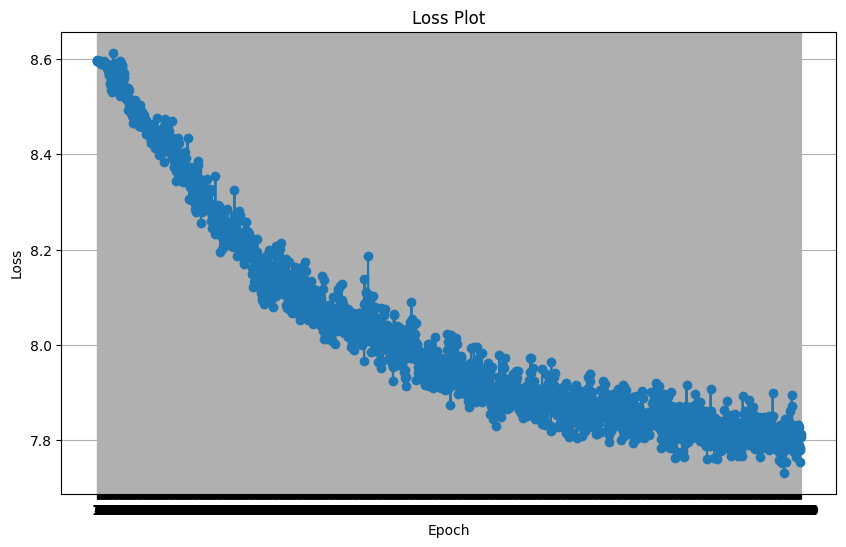

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Your array of values (I'll use a placeholder - please replace with your actual data)
values =[8.596006,
8.595876,
8.597139,
8.596519,
8.595129,
8.594834,
8.594284,
8.595858,
8.594429,
8.595078,
8.595137,
8.594590,
8.592047,
8.589904,
8.589159,
8.591260,
8.589964,
8.591159,
8.594131,
8.592586,
8.594419,
8.594815,
8.594656,
8.592539,
8.591977,
8.589427,
8.590639,
8.586500,
8.586847,
8.580038,
8.587210,
8.580708,
8.577686,
8.577633,
8.567214,
8.566328,
8.571039,
8.549139,
8.568344,
8.548080,
8.551861,
8.562126,
8.535286,
8.565214,
8.567122,
8.530144,
8.613089,
8.574005,
8.587893,
8.588625,
8.590458,
8.590521,
8.588872,
8.587450,
8.584399,
8.581055,
8.580298,
8.576321,
8.577150,
8.567896,
8.564291,
8.558061,
8.546877,
8.540675,
8.549647,
8.521797,
8.595058,
8.535704,
8.573298,
8.589502,
8.590959,
8.588074,
8.585939,
8.580584,
8.573219,
8.559604,
8.550637,
8.560148,
8.567961,
8.570526,
8.542055,
8.530334,
8.537781,
8.534211,
8.515762,
8.529541,
8.523432,
8.520903,
8.493847,
8.538614,
8.510803,
8.534033,
8.518116,
8.504646,
8.512663,
8.511644,
8.489998,
8.494989,
8.485816,
8.484276,
8.489323,
8.480867,
8.491924,
8.466376,
8.484583,
8.483163,
8.470028,
8.491852,
8.495893,
8.465403,
8.514130,
8.481730,
8.498713,
8.486353,
8.476986,
8.482101,
8.472907,
8.485771,
8.471548,
8.486437,
8.459514,
8.474073,
8.458902,
8.503918,
8.495747,
8.476784,
8.470705,
8.470093,
8.483845,
8.456933,
8.487812,
8.462775,
8.475565,
8.467854,
8.482801,
8.462973,
8.469580,
8.464397,
8.456732,
8.443215,
8.451399,
8.472528,
8.450018,
8.447002,
8.466282,
8.458909,
8.447002,
8.463275,
8.439102,
8.455372,
8.458320,
8.456246,
8.446735,
8.423714,
8.430546,
8.451387,
8.423773,
8.453251,
8.442394,
8.464614,
8.421465,
8.432116,
8.441869,
8.454956,
8.443050,
8.442232,
8.444906,
8.414288,
8.424082,
8.418938,
8.423065,
8.444612,
8.476810,
8.451986,
8.408510,
8.438586,
8.407427,
8.428329,
8.398357,
8.430827,
8.432692,
8.411940,
8.445566,
8.421601,
8.419913,
8.411028,
8.417467,
8.405210,
8.431585,
8.406687,
8.454531,
8.383738,
8.459994,
8.474360,
8.461900,
8.436587,
8.454868,
8.431007,
8.436614,
8.420094,
8.436065,
8.431290,
8.416143,
8.421597,
8.449194,
8.433411,
8.427170,
8.426918,
8.430826,
8.409011,
8.423464,
8.420647,
8.401449,
8.396048,
8.468838,
8.393316,
8.433180,
8.402363,
8.390278,
8.373014,
8.374170,
8.382244,
8.393970,
8.413813,
8.372779,
8.344784,
8.364067,
8.398109,
8.391159,
8.386274,
8.350371,
8.434237,
8.420603,
8.423824,
8.371106,
8.394093,
8.378711,
8.399643,
8.379669,
8.402340,
8.383299,
8.373810,
8.363094,
8.376211,
8.341131,
8.387193,
8.349173,
8.389932,
8.360463,
8.373372,
8.390491,
8.391030,
8.404210,
8.361276,
8.393185,
8.363651,
8.357283,
8.341528,
8.435253,
8.368652,
8.371518,
8.360943,
8.344257,
8.305546,
8.367611,
8.332260,
8.349728,
8.374430,
8.304314,
8.348099,
8.348742,
8.353653,
8.347363,
8.306013,
8.316488,
8.317032,
8.299505,
8.360840,
8.325922,
8.284967,
8.326653,
8.322929,
8.278555,
8.293266,
8.358885,
8.367064,
8.327858,
8.376707,
8.319012,
8.385470,
8.348782,
8.322266,
8.347764,
8.319166,
8.342651,
8.340468,
8.256973,
8.327967,
8.310479,
8.279247,
8.324730,
8.306320,
8.320208,
8.292179,
8.292184,
8.299784,
8.332369,
8.294105,
8.302159,
8.311932,
8.304228,
8.345286,
8.310770,
8.282982,
8.347395,
8.306118,
8.284957,
8.304279,
8.286629,
8.324148,
8.287671,
8.326389,
8.324760,
8.320962,
8.260345,
8.289385,
8.275520,
8.271271,
8.245823,
8.259858,
8.292822,
8.276592,
8.291857,
8.253056,
8.273859,
8.232397,
8.288088,
8.354757,
8.244652,
8.278944,
8.248722,
8.265139,
8.264753,
8.293423,
8.271627,
8.256207,
8.251282,
8.284190,
8.292143,
8.254860,
8.245296,
8.196037,
8.282122,
8.228872,
8.281840,
8.281864,
8.201684,
8.245617,
8.237655,
8.256680,
8.262893,
8.215386,
8.216955,
8.254091,
8.207561,
8.258089,
8.237911,
8.254402,
8.245581,
8.234589,
8.218622,
8.285284,
8.212090,
8.235111,
8.249203,
8.224097,
8.223189,
8.258921,
8.242331,
8.252048,
8.218212,
8.253380,
8.243000,
8.206662,
8.236170,
8.230232,
8.217821,
8.248493,
8.204788,
8.271851,
8.263163,
8.326050,
8.229507,
8.264082,
8.251385,
8.207074,
8.221829,
8.240509,
8.185934,
8.236425,
8.226437,
8.265785,
8.216236,
8.281746,
8.214371,
8.267498,
8.272108,
8.194901,
8.209707,
8.194809,
8.190655,
8.234470,
8.217146,
8.210245,
8.232944,
8.212767,
8.198351,
8.215048,
8.169817,
8.175008,
8.188881,
8.201118,
8.258344,
8.257557,
8.242281,
8.196789,
8.214066,
8.223599,
8.229284,
8.236193,
8.236053,
8.232557,
8.202061,
8.215832,
8.181674,
8.205179,
8.194811,
8.202018,
8.199092,
8.211864,
8.162590,
8.186845,
8.148056,
8.183960,
8.120829,
8.222846,
8.147833,
8.131922,
8.196634,
8.136065,
8.145432,
8.181505,
8.159142,
8.123848,
8.195460,
8.159129,
8.221716,
8.174296,
8.158609,
8.152283,
8.140196,
8.149862,
8.156134,
8.152826,
8.181740,
8.152239,
8.108461,
8.114599,
8.128882,
8.097801,
8.095072,
8.106760,
8.117626,
8.141602,
8.107223,
8.086630,
8.144156,
8.139578,
8.173813,
8.182413,
8.162849,
8.182408,
8.189390,
8.121712,
8.181630,
8.153793,
8.171576,
8.120547,
8.198901,
8.130569,
8.109085,
8.108762,
8.130991,
8.130025,
8.165691,
8.095741,
8.092889,
8.105799,
8.148742,
8.079396,
8.110426,
8.102388,
8.106394,
8.189344,
8.155272,
8.131124,
8.147982,
8.142683,
8.102037,
8.130856,
8.208083,
8.138903,
8.121472,
8.149785,
8.126295,
8.134486,
8.151754,
8.140926,
8.189088,
8.200539,
8.111656,
8.120464,
8.144236,
8.154984,
8.214607,
8.134066,
8.115379,
8.169463,
8.115971,
8.164558,
8.106462,
8.141565,
8.172542,
8.113159,
8.124908,
8.129045,
8.084479,
8.111914,
8.180873,
8.123356,
8.102697,
8.078001,
8.094958,
8.085230,
8.119826,
8.175011,
8.140557,
8.101285,
8.139372,
8.095474,
8.073692,
8.128662,
8.149018,
8.086784,
8.087400,
8.068071,
8.076853,
8.114130,
8.102115,
8.149836,
8.098155,
8.129527,
8.113487,
8.110614,
8.162920,
8.113157,
8.102201,
8.128256,
8.115610,
8.119101,
8.125679,
8.112946,
8.120078,
8.062428,
8.074902,
8.067715,
8.147616,
8.150509,
8.053202,
8.124802,
8.129114,
8.106028,
8.071035,
8.135607,
8.163794,
8.117336,
8.123713,
8.129375,
8.138744,
8.085348,
8.174334,
8.106384,
8.088034,
8.125807,
8.126896,
8.155682,
8.076736,
8.099004,
8.060297,
8.084122,
8.107529,
8.053457,
8.107634,
8.078638,
8.092354,
8.074696,
8.100180,
8.134582,
8.092793,
8.076342,
8.112228,
8.058241,
8.118666,
8.104853,
8.044338,
8.097401,
8.093572,
8.095263,
8.091515,
8.075521,
8.054677,
8.115738,
8.081977,
8.111382,
8.093124,
8.062254,
8.051812,
8.067741,
8.094391,
8.062229,
8.060129,
8.045507,
8.092176,
8.044182,
8.082621,
8.080313,
8.039330,
8.097802,
8.046759,
8.080549,
8.144634,
8.116705,
8.076276,
8.030336,
8.083710,
8.012383,
8.137049,
8.043173,
8.042061,
8.051724,
8.027687,
8.034619,
8.012749,
8.053078,
8.072456,
8.035431,
8.025019,
8.071488,
8.083046,
8.040681,
8.034290,
8.060452,
8.023778,
8.038166,
8.014405,
8.041153,
8.068446,
8.068785,
8.011305,
8.008014,
8.026716,
8.099895,
8.076674,
8.060595,
8.054188,
8.002621,
8.032629,
8.069822,
8.049228,
8.071357,
8.040173,
8.035429,
8.063412,
8.028772,
8.115854,
8.072020,
8.117155,
8.066049,
8.042704,
8.063532,
8.089768,
8.124298,
8.071164,
8.074909,
8.071157,
8.127577,
8.056782,
8.094407,
8.085407,
8.055594,
8.068558,
8.031242,
8.066854,
8.025423,
8.059611,
8.042824,
8.065310,
8.061299,
8.038479,
8.056223,
8.038754,
8.044621,
8.074604,
8.025998,
8.015919,
8.040930,
8.022973,
8.038512,
8.029737,
8.025659,
8.043852,
8.031321,
8.043255,
7.995591,
8.039928,
8.004637,
8.066262,
8.016841,
8.030091,
8.020575,
8.023888,
7.989933,
8.023482,
8.019069,
8.024372,
8.028358,
8.046958,
8.045164,
8.032874,
8.052614,
8.008265,
8.036231,
8.028589,
8.055527,
8.066805,
8.067913,
8.047272,
8.025715,
8.022291,
8.042229,
8.017111,
8.032558,
8.067380,
8.000796,
8.065754,
8.032893,
8.039301,
8.030693,
8.085207,
7.967330,
8.137958,
8.020321,
8.088232,
8.110086,
8.075411,
8.110516,
8.066866,
8.083950,
8.038365,
8.008261,
8.187443,
8.058245,
8.030651,
8.057711,
8.105103,
8.089203,
8.041094,
8.039294,
8.063902,
7.985824,
8.020362,
8.037579,
8.066891,
8.065687,
8.064413,
8.102615,
7.988286,
8.036331,
8.051693,
8.038231,
8.050203,
8.078748,
8.001243,
8.011882,
8.017733,
7.992999,
8.053740,
7.986291,
8.018103,
7.964901,
8.026519,
7.993877,
8.022566,
8.007812,
8.055737,
7.969323,
7.951645,
8.023309,
8.077971,
8.022617,
8.003030,
7.966559,
8.029693,
7.993063,
8.040118,
8.063186,
8.016129,
8.013301,
8.037758,
8.074545,
7.988693,
8.010326,
8.025195,
8.016130,
8.033094,
8.042742,
8.036913,
8.017361,
7.971665,
8.018618,
8.015749,
8.003599,
7.986338,
7.987634,
7.973723,
8.018232,
8.024651,
7.987888,
7.966375,
7.959473,
7.953928,
7.925387,
7.993329,
8.063351,
7.977053,
8.064125,
7.972473,
8.010159,
7.975998,
7.962383,
7.994831,
8.039009,
7.998017,
7.990727,
8.014633,
7.961777,
7.958893,
8.003792,
8.022247,
8.037226,
7.957194,
7.957265,
7.993690,
7.997695,
7.985206,
7.974764,
7.975858,
8.014533,
7.990686,
7.971929,
8.009328,
7.942599,
8.031644,
7.993838,
7.930324,
7.997882,
7.947711,
7.933679,
7.914947,
7.972842,
8.007192,
8.034347,
7.975999,
8.032328,
8.024014,
8.021387,
8.011642,
8.020646,
8.048238,
7.984525,
7.972420,
7.989198,
7.978752,
8.091175,
7.971755,
8.025557,
8.053593,
8.039959,
7.991348,
8.047096,
8.021336,
8.008465,
7.970614,
8.022980,
8.008859,
8.047224,
7.927218,
7.994260,
7.995005,
7.999864,
8.002999,
7.975634,
7.942080,
7.953581,
7.978256,
7.961596,
7.947201,
7.943769,
7.937015,
7.978509,
7.985915,
7.944189,
7.974976,
7.961931,
7.938185,
7.927634,
7.963541,
7.933418,
7.942736,
7.945488,
7.932386,
7.921667,
7.975432,
7.916882,
7.949984,
7.974017,
7.935823,
7.933814,
7.990303,
7.958014,
7.960382,
8.001374,
7.914744,
7.990440,
7.922751,
8.002076,
7.965191,
7.947261,
7.985962,
7.921619,
7.925053,
7.936210,
7.924351,
7.910501,
7.921645,
7.911880,
7.981591,
7.916265,
7.944251,
7.949833,
7.945330,
8.016606,
7.980477,
7.963820,
7.936094,
7.987933,
7.955631,
7.970186,
7.941791,
7.935889,
7.937682,
7.944354,
7.942098,
7.929559,
7.913504,
7.936430,
7.963418,
7.908867,
7.972434,
7.942837,
7.914266,
7.941841,
7.915699,
7.928794,
7.925496,
7.948329,
7.913917,
7.954751,
7.939718,
7.905771,
7.918109,
7.949332,
7.933379,
7.989841,
7.938556,
8.022099,
7.966440,
7.908152,
8.006268,
7.933401,
7.958727,
7.922345,
7.975165,
8.010753,
7.873676,
8.020409,
7.978661,
7.934174,
7.984945,
7.994472,
7.942416,
7.944804,
7.915553,
8.004107,
7.983913,
7.986911,
7.955892,
7.955507,
7.962010,
8.014418,
7.949939,
7.940763,
8.003140,
7.945505,
7.922093,
7.936455,
7.896628,
7.952210,
7.913352,
7.939601,
7.930442,
7.904688,
7.952554,
7.972950,
7.964723,
7.976858,
7.935679,
7.905600,
7.902258,
7.951181,
7.904819,
7.935505,
7.924772,
7.936930,
7.898007,
7.933478,
7.923185,
7.935891,
7.899064,
7.941881,
7.943219,
7.895662,
7.923918,
7.882708,
7.912716,
7.894504,
7.909102,
7.869314,
7.911219,
7.961497,
7.945863,
7.893714,
7.911961,
7.994653,
7.893059,
7.955859,
7.934812,
7.890928,
7.949457,
7.908700,
7.891075,
7.996118,
7.891307,
7.890204,
7.933494,
7.922933,
7.915466,
7.880202,
7.934856,
7.925221,
7.996404,
7.970206,
7.957787,
7.942177,
7.951548,
7.940812,
7.934465,
7.910747,
7.920431,
7.897135,
7.942036,
7.902022,
7.983629,
7.949481,
7.881102,
7.896256,
7.913798,
7.907421,
7.950995,
7.883987,
7.946458,
7.934787,
7.952538,
7.911302,
7.932004,
7.908576,
7.891985,
7.910169,
7.917915,
7.923560,
7.962570,
7.935281,
7.930579,
7.922236,
7.907055,
7.940565,
7.854592,
7.947336,
7.871588,
7.883973,
7.884575,
7.953506,
7.874143,
7.891596,
7.904140,
7.844733,
7.868558,
7.885112,
7.897982,
7.863269,
7.877782,
7.882434,
7.892339,
7.862765,
7.829280,
7.914917,
7.867136,
7.897554,
7.882268,
7.933872,
7.915580,
7.915308,
7.890379,
7.978566,
7.928114,
7.891335,
7.864576,
7.848679,
7.890481,
7.898510,
7.918982,
7.879808,
7.933684,
7.955567,
7.908627,
7.866495,
7.915075,
7.952596,
7.972823,
7.894349,
7.884299,
7.901535,
7.874804,
7.924190,
7.865916,
7.897481,
7.906514,
7.924657,
7.891794,
7.882077,
7.874754,
7.868597,
7.916039,
7.903471,
7.915051,
7.872222,
7.930190,
7.910541,
7.899189,
7.906444,
7.876743,
7.938722,
7.921926,
7.889468,
7.918149,
7.903146,
7.926749,
7.888581,
7.894850,
7.924847,
7.876623,
7.945221,
7.931429,
7.909097,
7.897385,
7.945292,
7.880907,
7.908180,
7.887980,
7.863567,
7.874255,
7.902197,
7.868165,
7.878778,
7.857869,
7.896246,
7.904182,
7.898852,
7.863901,
7.909911,
7.846163,
7.885608,
7.893342,
7.892888,
7.909903,
7.883102,
7.876667,
7.864188,
7.884992,
7.914270,
7.851302,
7.881049,
7.873001,
7.900970,
7.854117,
7.881958,
7.905605,
7.866574,
7.926364,
7.871092,
7.973291,
7.943044,
7.940449,
7.972445,
7.914733,
7.872855,
7.916556,
7.921198,
7.952493,
7.855198,
7.883621,
7.860688,
7.925506,
7.877136,
7.844227,
7.866622,
7.899736,
7.882423,
7.859167,
7.909051,
7.901402,
7.845141,
7.892091,
7.879458,
7.884745,
7.877995,
7.873486,
7.868063,
7.894980,
7.871767,
7.862840,
7.891734,
7.860826,
7.879893,
7.949665,
7.835097,
7.864005,
7.878434,
7.851827,
7.880246,
7.877753,
7.876086,
7.831540,
7.909544,
7.906436,
7.912261,
7.938649,
7.896539,
7.876792,
7.833379,
7.869740,
7.920703,
7.902707,
7.905789,
7.924015,
7.876303,
7.885695,
7.921951,
7.830796,
7.818975,
7.964074,
7.875938,
7.863288,
7.872951,
7.936960,
7.873066,
7.885932,
7.910979,
7.916688,
7.932821,
7.941328,
7.864121,
7.903405,
7.910444,
7.854982,
7.879440,
7.890164,
7.852748,
7.905283,
7.853888,
7.828421,
7.863683,
7.872436,
7.859214,
7.867846,
7.882336,
7.836261,
7.882144,
7.881804,
7.838696,
7.892005,
7.895611,
7.861478,
7.873847,
7.912779,
7.825945,
7.880009,
7.856948,
7.846695,
7.871562,
7.888679,
7.921143,
7.911077,
7.816179,
7.893581,
7.819538,
7.830321,
7.850072,
7.890827,
7.884475,
7.871340,
7.807273,
7.851834,
7.840779,
7.869109,
7.843611,
7.848383,
7.888621,
7.838889,
7.861750,
7.816463,
7.898097,
7.842288,
7.838582,
7.908856,
7.885014,
7.867964,
7.880124,
7.909708,
7.911398,
7.896159,
7.915486,
7.873983,
7.805736,
7.850233,
7.856767,
7.842520,
7.859156,
7.841408,
7.829492,
7.829270,
7.833703,
7.851782,
7.903080,
7.861756,
7.872202,
7.855263,
7.836576,
7.808916,
7.872902,
7.854177,
7.852832,
7.821511,
7.842623,
7.846101,
7.834249,
7.888539,
7.818813,
7.828426,
7.824786,
7.844054,
7.830327,
7.871622,
7.932792,
7.910880,
7.856062,
7.900578,
7.874263,
7.871914,
7.939643,
7.940042,
7.925310,
7.899439,
7.847478,
7.897440,
7.870230,
7.901562,
7.827140,
7.885375,
7.847042,
7.872613,
7.872553,
7.830505,
7.857361,
7.822988,
7.861501,
7.813864,
7.851875,
7.875978,
7.814169,
7.834008,
7.847221,
7.866119,
7.862872,
7.836810,
7.843036,
7.869841,
7.864012,
7.872048,
7.905951,
7.817253,
7.865428,
7.887760,
7.846517,
7.854233,
7.880983,
7.868840,
7.855194,
7.924574,
7.856935,
7.903920,
7.900358,
7.879458,
7.919250,
7.887477,
7.884201,
7.865620,
7.882192,
7.819168,
7.820434,
7.851840,
7.827344,
7.872235,
7.834915,
7.810826,
7.796052,
7.830620,
7.894359,
7.845855,
7.825569,
7.820102,
7.825371,
7.836068,
7.858076,
7.861411,
7.828757,
7.897424,
7.831202,
7.888391,
7.854767,
7.844154,
7.889452,
7.875012,
7.836975,
7.856732,
7.853146,
7.881016,
7.866170,
7.907033,
7.844543,
7.832905,
7.836958,
7.832489,
7.838350,
7.843005,
7.843336,
7.848620,
7.801747,
7.838433,
7.855730,
7.891706,
7.868493,
7.823863,
7.822480,
7.915298,
7.808411,
7.912178,
7.865680,
7.872630,
7.892351,
7.865116,
7.859955,
7.860876,
7.905819,
7.881508,
7.844873,
7.834329,
7.857906,
7.881915,
7.882886,
7.871171,
7.837705,
7.818734,
7.823387,
7.822401,
7.841337,
7.826864,
7.834073,
7.811841,
7.846142,
7.814127,
7.831962,
7.795095,
7.891485,
7.842873,
7.852789,
7.831872,
7.858253,
7.874785,
7.893340,
7.844903,
7.802660,
7.804743,
7.852527,
7.842201,
7.823704,
7.818474,
7.808749,
7.838651,
7.825047,
7.851765,
7.827611,
7.866704,
7.858799,
7.835747,
7.848426,
7.903213,
7.814346,
7.835269,
7.852038,
7.889894,
7.806964,
7.849572,
7.855869,
7.804854,
7.812235,
7.855431,
7.831236,
7.810755,
7.837978,
7.815797,
7.832199,
7.810867,
7.859557,
7.831513,
7.842427,
7.812663,
7.839219,
7.811579,
7.858773,
7.829261,
7.857922,
7.848334,
7.901802,
7.856245,
7.860064,
7.878131,
7.843040,
7.853675,
7.863966,
7.881358,
7.855484,
7.866086,
7.843672,
7.850327,
7.884661,
7.903246,
7.898228,
7.919390,
7.832893,
7.847927,
7.909222,
7.855586,
7.828054,
7.873248,
7.914901,
7.834718,
7.833567,
7.879783,
7.828954,
7.819912,
7.802227,
7.783058,
7.816828,
7.858863,
7.825791,
7.828441,
7.814859,
7.826994,
7.878171,
7.816572,
7.897739,
7.867085,
7.796994,
7.856766,
7.864326,
7.811573,
7.862378,
7.850551,
7.874710,
7.893463,
7.812445,
7.891987,
7.837241,
7.786671,
7.851417,
7.835773,
7.812647,
7.783943,
7.902141,
7.855671,
7.798958,
7.823880,
7.872306,
7.784980,
7.783131,
7.818790,
7.813848,
7.828073,
7.827002,
7.762508,
7.819596,
7.851718,
7.861428,
7.821936,
7.802498,
7.776334,
7.808340,
7.820189,
7.818019,
7.831498,
7.871161,
7.822648,
7.840793,
7.864154,
7.833967,
7.828213,
7.818819,
7.836769,
7.803021,
7.853451,
7.825321,
7.817449,
7.818429,
7.807854,
7.777404,
7.823174,
7.765467,
7.792321,
7.807583,
7.844346,
7.826328,
7.872094,
7.847649,
7.916707,
7.806108,
7.817966,
7.859917,
7.796948,
7.838820,
7.860314,
7.837813,
7.804916,
7.809328,
7.838637,
7.862880,
7.855422,
7.806879,
7.843196,
7.804795,
7.814383,
7.872042,
7.822441,
7.864956,
7.837898,
7.861633,
7.825532,
7.806340,
7.898015,
7.833368,
7.809726,
7.877254,
7.827888,
7.845146,
7.846347,
7.813616,
7.826283,
7.865173,
7.878730,
7.821898,
7.880604,
7.797708,
7.880622,
7.865580,
7.851808,
7.849419,
7.820886,
7.862080,
7.833667,
7.819783,
7.801506,
7.835605,
7.824648,
7.810266,
7.822775,
7.792369,
7.862419,
7.823815,
7.787962,
7.803332,
7.827421,
7.816329,
7.760278,
7.860069,
7.826062,
7.823655,
7.818135,
7.821621,
7.862218,
7.839202,
7.788949,
7.806472,
7.908768,
7.861039,
7.805353,
7.802782,
7.807141,
7.799986,
7.815039,
7.824606,
7.810724,
7.847924,
7.763002,
7.818541,
7.814312,
7.847395,
7.785718,
7.802464,
7.836833,
7.805215,
7.760653,
7.814160,
7.790522,
7.817963,
7.821471,
7.801761,
7.810198,
7.783567,
7.841642,
7.810144,
7.794496,
7.777248,
7.817662,
7.802981,
7.813702,
7.811703,
7.810143,
7.786685,
7.792162,
7.808046,
7.862852,
7.819057,
7.830376,
7.804987,
7.814764,
7.794778,
7.843723,
7.788507,
7.799132,
7.883486,
7.848915,
7.847735,
7.845070,
7.828776,
7.802808,
7.781098,
7.803274,
7.788027,
7.850048,
7.825037,
7.767035,
7.852551,
7.833619,
7.807575,
7.776363,
7.799078,
7.830209,
7.801151,
7.834408,
7.788638,
7.856135,
7.792437,
7.770900,
7.839746,
7.822501,
7.828684,
7.781866,
7.827482,
7.802060,
7.837070,
7.806442,
7.767828,
7.777666,
7.827061,
7.819154,
7.836143,
7.819417,
7.777595,
7.808915,
7.795535,
7.766633,
7.812825,
7.804368,
7.893926,
7.834674,
7.811188,
7.855671,
7.829058,
7.809992,
7.829413,
7.860837,
7.853220,
7.804530,
7.848246,
7.858489,
7.814991,
7.847963,
7.858683,
7.789762,
7.797912,
7.884244,
7.804444,
7.849812,
7.810422,
7.833432,
7.801543,
7.809460,
7.825265,
7.796842,
7.794474,
7.829312,
7.819504,
7.870865,
7.820442,
7.784751,
7.853703,
7.796794,
7.803033,
7.811700,
7.782353,
7.801225,
7.838031,
7.817252,
7.797993,
7.824434,
7.836963,
7.817607,
7.792821,
7.804690,
7.849935,
7.781699,
7.786613,
7.805206,
7.764416,
7.794923,
7.791197,
7.799077,
7.824569,
7.797795,
7.784251,
7.798108,
7.790007,
7.786855,
7.837058,
7.849183,
7.819018,
7.811798,
7.801661,
7.798034,
7.831556,
7.829473,
7.797203,
7.797947,
7.784016,
7.819252,
7.843868,
7.847219,
7.851720,
7.779818,
7.785686,
7.837912,
7.801894,
7.842947,
7.817704,
7.831306,
7.800957,
7.813871,
7.784656,
7.899184,
7.821005,
7.850779,
7.799372,
7.796560,
7.789982,
7.814175,
7.828045,
7.782034,
7.790791,
7.815908,
7.801861,
7.795609,
7.799754,
7.802658,
7.814052,
7.801333,
7.758196,
7.790353,
7.775413,
7.757710,
7.833172,
7.776918,
7.790306,
7.810871,
7.757268,
7.782658,
7.752920,
7.777237,
7.827362,
7.813318,
7.777793,
7.807329,
7.732134,
7.796267,
7.779956,
7.845026,
7.781389,
7.755670,
7.811792,
7.803310,
7.790769,
7.839550,
7.807633,
7.837446,
7.816940,
7.819574,
7.837501,
7.826651,
7.860988,
7.790205,
7.831059,
7.829656,
7.814283,
7.895927,
7.871339,
7.816510,
7.832157,
7.820984,
7.777222,
7.797720,
7.817968,
7.777694,
7.776151,
7.822425,
7.772100,
7.798322,
7.765032,
7.787261,
7.786590,
7.785890,
7.810937,
7.831933,
7.831350,
7.781004,
7.790715,
7.827704,
7.753944,
7.779425,
7.784297,
7.806862,
7.813114]
# Create the x-axis values from 1 to length of the array
x = np.arange(1, len(values) + 1)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, values, marker='o')  # 'o' adds points at each data point
plt.title('Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)  # Adds grid lines
plt.xticks(x)  # Ensures x-axis shows whole numbers 1, 2, 3, etc.

# Show the plot
plt.show()